In [60]:
import os
import numpy as np
import pandas as pd
import umap
import time
from Bio import SeqIO

target_uniprots = ["P37840", "P04637", "P02686", "P07305", "O00488", "Q9NYB9", "P06401", "Q16186", "S6B291", "P23441"]

# P37840: alpha synyclein 100%
# P04637: p53 37%
# P02686: myelin 56%
# P07305: histone h1 57%
# O00488: zing finger 55%
# Q9NYB9: abl interactor 2 69%
# P06401: progesterone receptor 63%
# Q16186: Proteasomal ubiquitin receptor ADRM1
# S6B291: IgG H chain
# P23441: Homeobox protein nkx

In [61]:
def get_kmers(seq, K=30):
    start = 0
    end   = len(seq)
    kmers = list()
    ranges= list()
    for i in range(start, end):
        if i > len(seq)-K or ((i+K)>len(seq)):
            break
        else:
            kmers.append(seq[i:i+K])
            ranges.append(f"{i}_{i+K}")
    return kmers, ranges

def get_embedding_kmers(emb, K=30):
    start = 0
    aa_len= emb.shape[0]
    end   = aa_len ## aa length
    kmers = list()
    ranges= list()
    for i in range(start, end):
        if i > aa_len-K or ((i+K)>aa_len):
            break
        else:
            kmers.append(emb[i:i+K,:])
            # ranges.append(f"{i}_{i+K}")
    return kmers

def get_sequences(fastadir=None, fastafile=None):
    sequences = []
    if fastadir is None and fastafile is None:
        print("No fasta dir or file")
        raise
    if fastadir is not None and fastafile is not None:
        print("Choose one, fasta dir or multi fasta filr")
        raise
    # check for a directory with individual fasta files
    # or a multi fasta file
    if fastadir is not None:
        fastafiles = os.listdir(fastadir)
        for f in fastafiles:
            counter = 0
            for record in SeqIO.parse(os.path.join(fastadir, f), "fasta"):
                sequences.append(record)
                counter += 1
                if counter > 1:
                    print("More than one fasta record?", f)
                    raise
    elif fastafile is not None:
        for record in SeqIO.parse(fastafile, "fasta"):
            sequences.append(record)
    return sequences

In [62]:
# Load disprot embedding and annot data

# Disprot
embeddir="/data/franco/datasets/prot_embedding_weights/disprot/halft5/"
fasta_dir = "/data/franco/datasets/disprot/fasta/"
fasta_files = os.listdir(fasta_dir)
counter = 0

# find annotation for each sequence
annotfile = "/data/franco/datasets/disprot/DisProt_release_2022_06_reformat_annot.fasta"
annotdir  = None
annots    = get_sequences(fastadir=annotdir, fastafile=annotfile)

annot_dict = dict()
for record in annots:
    if "|" in record.name:
        name = record.name.split("|")[1].strip()
    else:
        name = record.name.split()[0].strip()
        if name == "":
            print("Name is empty",record.name)
    annot_dict[name] = str(record.seq)

embeddings = list()
uniprots   = list()
disprot_annotations = list()
for ff in fasta_files:
    uniprot_id = ff.rstrip().split(".")[0]
    if uniprot_id in target_uniprots:
        embedfile = os.path.join(embeddir, f"{uniprot_id}.gz")
        if os.path.exists(embedfile):
            emb = np.loadtxt(embedfile)
            if emb.shape[0] == len(annot_dict[uniprot_id]):
                embeddings.append(emb)
                uniprots.append(uniprot_id)
                disprot_annotations.append(annot_dict[uniprot_id])
                counter += 1
            else:
                print("Embedding length and annot do not match")
                print(emb.shape, len(annot_dict[uniprot_id]), uniprot_id)
print(f"Loaded {counter} protein embeddings")

Loaded 10 protein embeddings


In [63]:
# obtain kmer embeddings from original whole protein embedding, and apply mean function
K = 30
disprot_kmer_mean_embeddings = list()
length_list = list()
for single_emb in embeddings:
    emb_kmer  = get_embedding_kmers(single_emb, K=K)
    length_list.append(len(emb_kmer))
    emb_kmers = [np.mean(x, axis=0) for x in emb_kmer] # make a list of mean embedding kmers
    disprot_kmer_mean_embeddings = disprot_kmer_mean_embeddings + emb_kmers
print(len(disprot_kmer_mean_embeddings))

3566


In [64]:
# obtain kmer annotations
disprot_kmer_annotations = list()
length_list_annots = list()
for dannot in disprot_annotations:
    annot_kmers, annot_ranges = get_kmers(dannot, K=K)
    length_list_annots.append(len(annot_kmers))
    for kmer in annot_kmers:
        disprot_kmer_annotations.append(kmer)

In [65]:
print(embeddings[0].shape)
print(len(disprot_kmer_annotations))
print(np.array(disprot_kmer_mean_embeddings).shape)

(140, 1024)
3566
(3566, 1024)


In [66]:
def get_contents(annotations):
    disorder_contents = list()
    for da in annotations:
        contents = [ x != "-" for x in da]
        DC = np.sum(contents) / len(contents)
        disorder_contents.append(DC)
    return disorder_contents

disprot_kmer_disorder_contents = get_contents(disprot_kmer_annotations)
print(len(disprot_kmer_disorder_contents))

3566


In [67]:
print(f"DIFF={len(disprot_kmer_disorder_contents) - np.array(disprot_kmer_mean_embeddings).shape[0]}")

DIFF=0


In [68]:
import umap
my_umap = umap.UMAP(n_neighbors=200, min_dist=.25)
umap_embedding = my_umap.fit_transform(np.array(disprot_kmer_mean_embeddings))


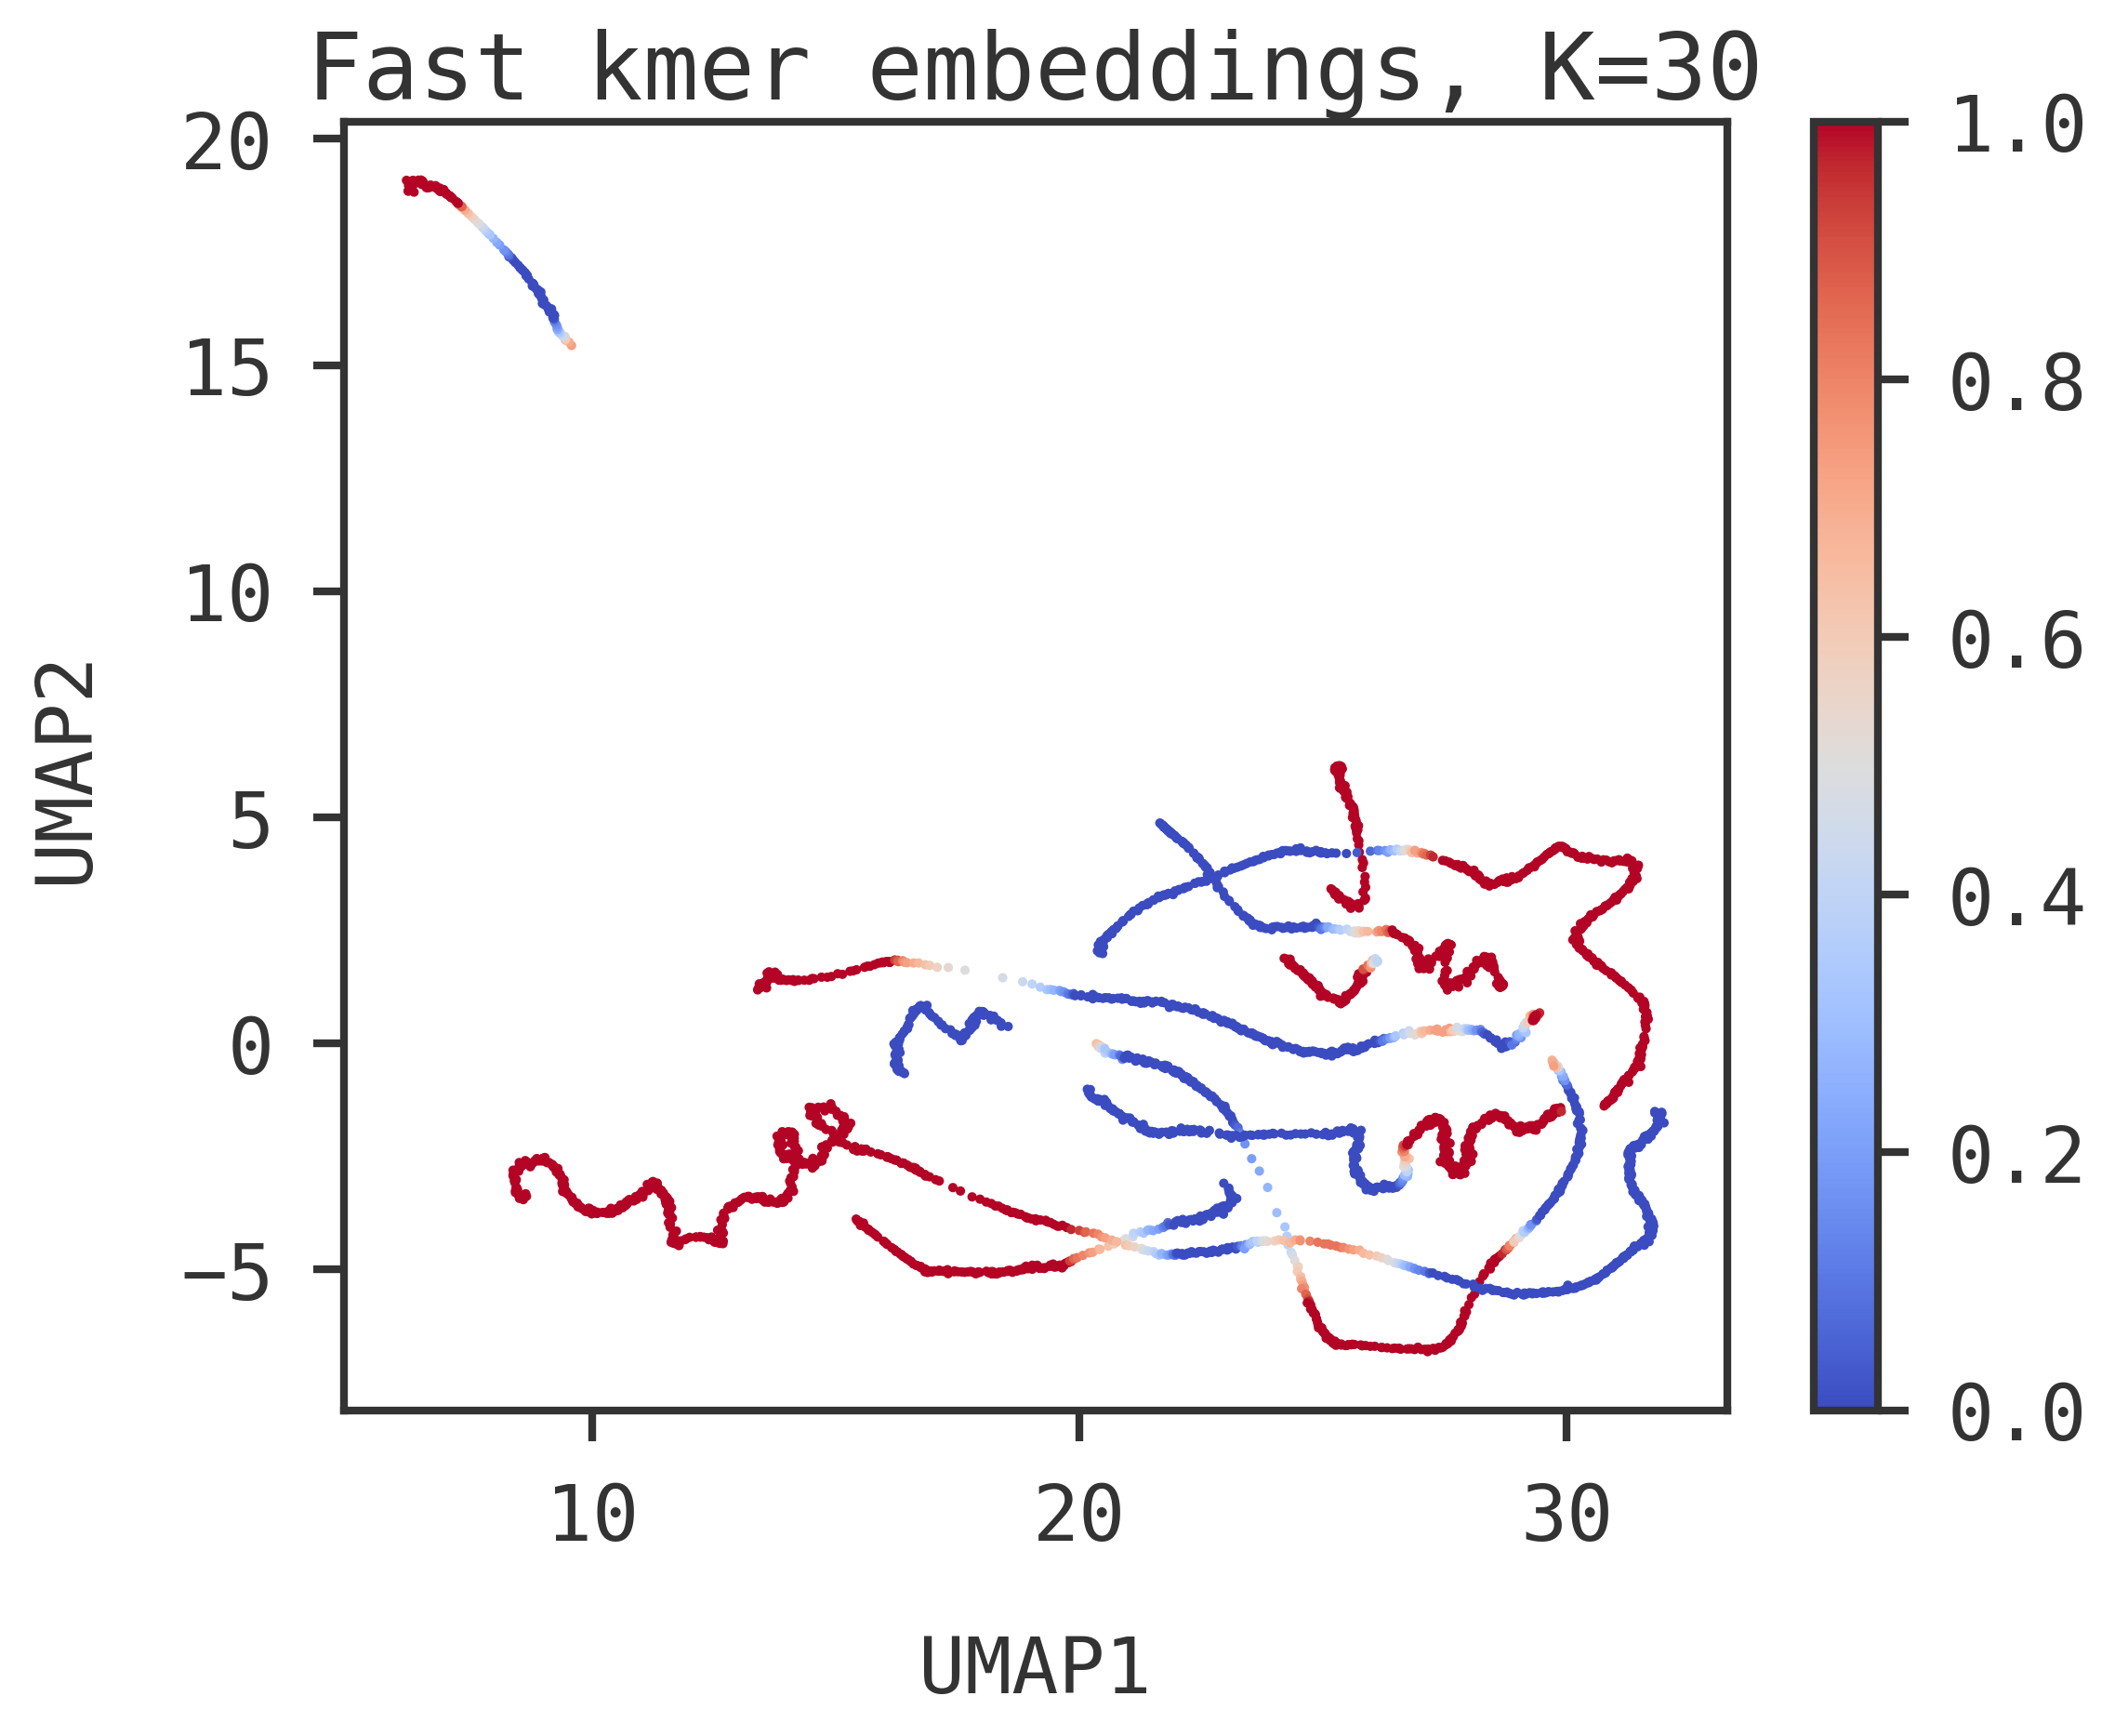

In [69]:
# Second: PLOT
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import mpl_stylesheet
mpl_stylesheet.banskt_presentation(fontfamily = 'mono', fontsize = 20, colors = 'banskt', dpi = 300)


fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(111)

cmap = plt.get_cmap("coolwarm")
sc = ax1.scatter(umap_embedding[:,0], umap_embedding[:,1], c=disprot_kmer_disorder_contents, s=2, cmap=cmap)
ax1.set_xlabel("UMAP1")
ax1.set_ylabel("UMAP2")
ax1.set_title(f"Fast kmer embeddings, K={K}")
plt.colorbar(sc, ax=ax1)
plt.savefig(f"plots/kmers_embeddings_k{K}.png", bbox_inches='tight')
plt.show()

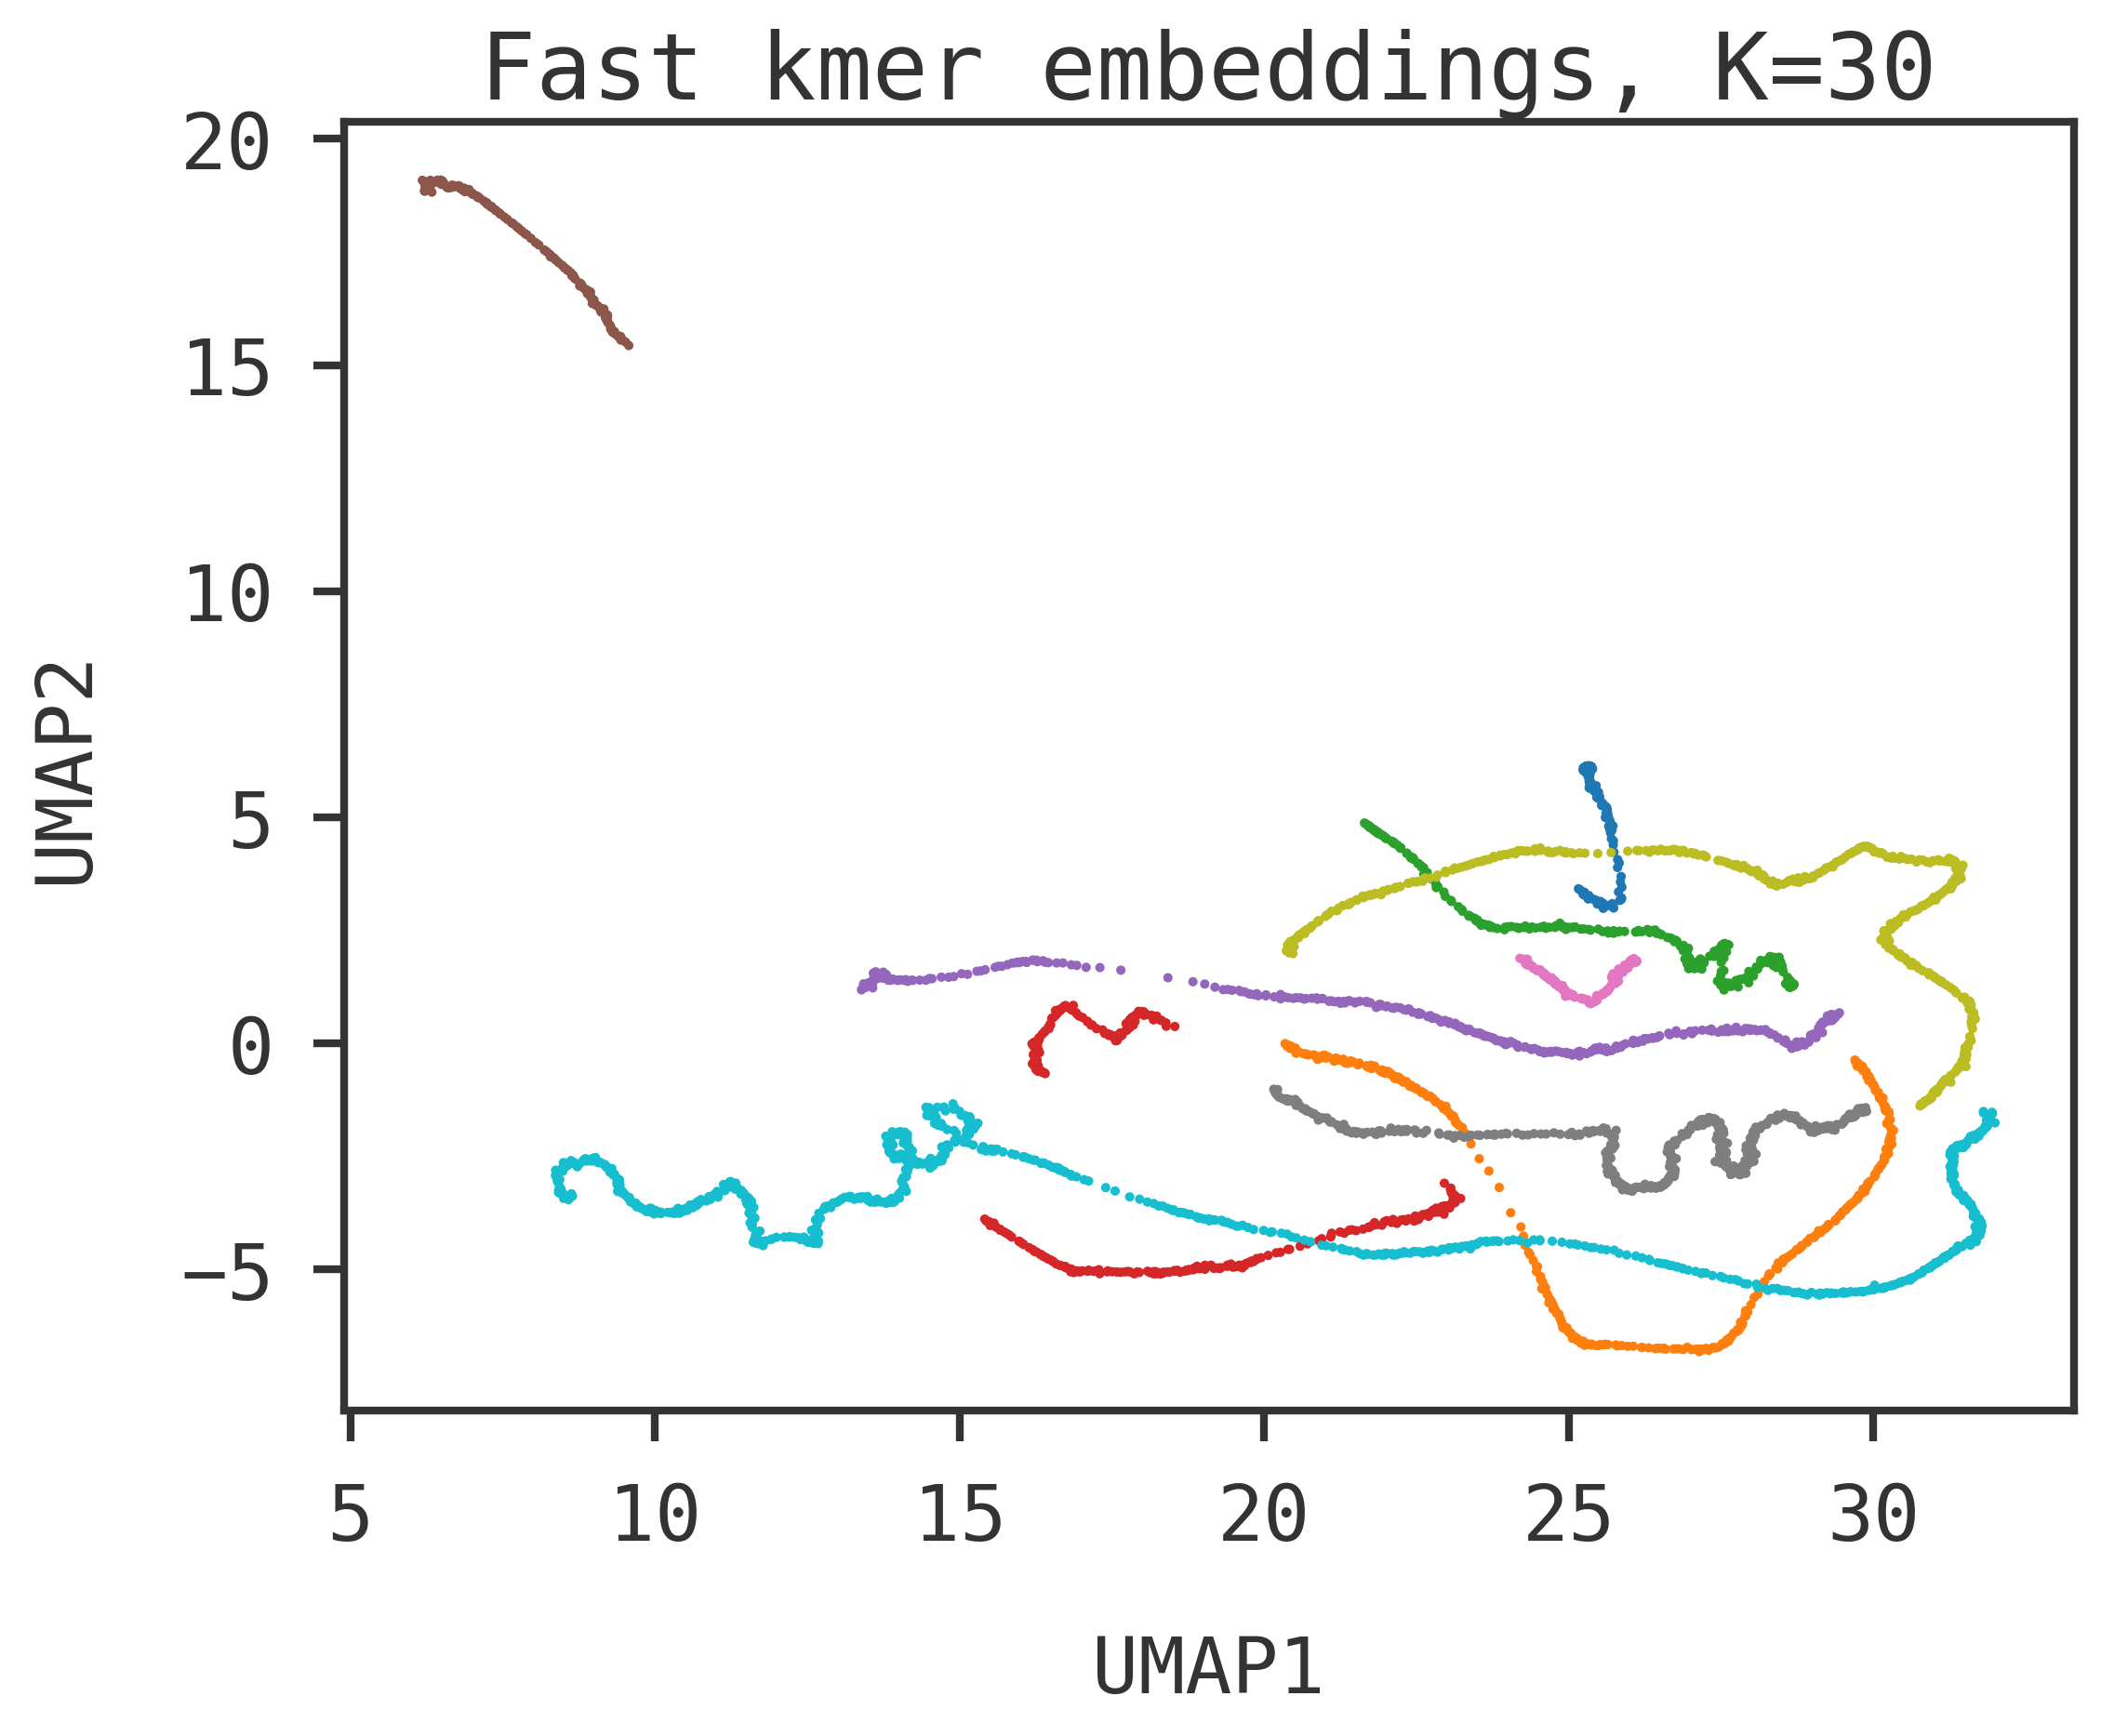

In [73]:
prot_colors = list()
for i,l in enumerate(length_list):
    prot_colors = prot_colors + list(np.repeat(i/len(length_list), l))

fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(111)

cmap = plt.get_cmap("tab10")
sc = ax1.scatter(umap_embedding[:,0], umap_embedding[:,1], c=prot_colors, s=2, cmap=cmap)
ax1.set_xlabel("UMAP1")
ax1.set_ylabel("UMAP2")
ax1.set_title(f"Fast kmer embeddings, K={K}")
# plt.colorbar(sc, ax=ax1)
plt.savefig(f"plots/kmers_embeddings_k{K}_byprot.png", bbox_inches='tight')
plt.show()

P37840


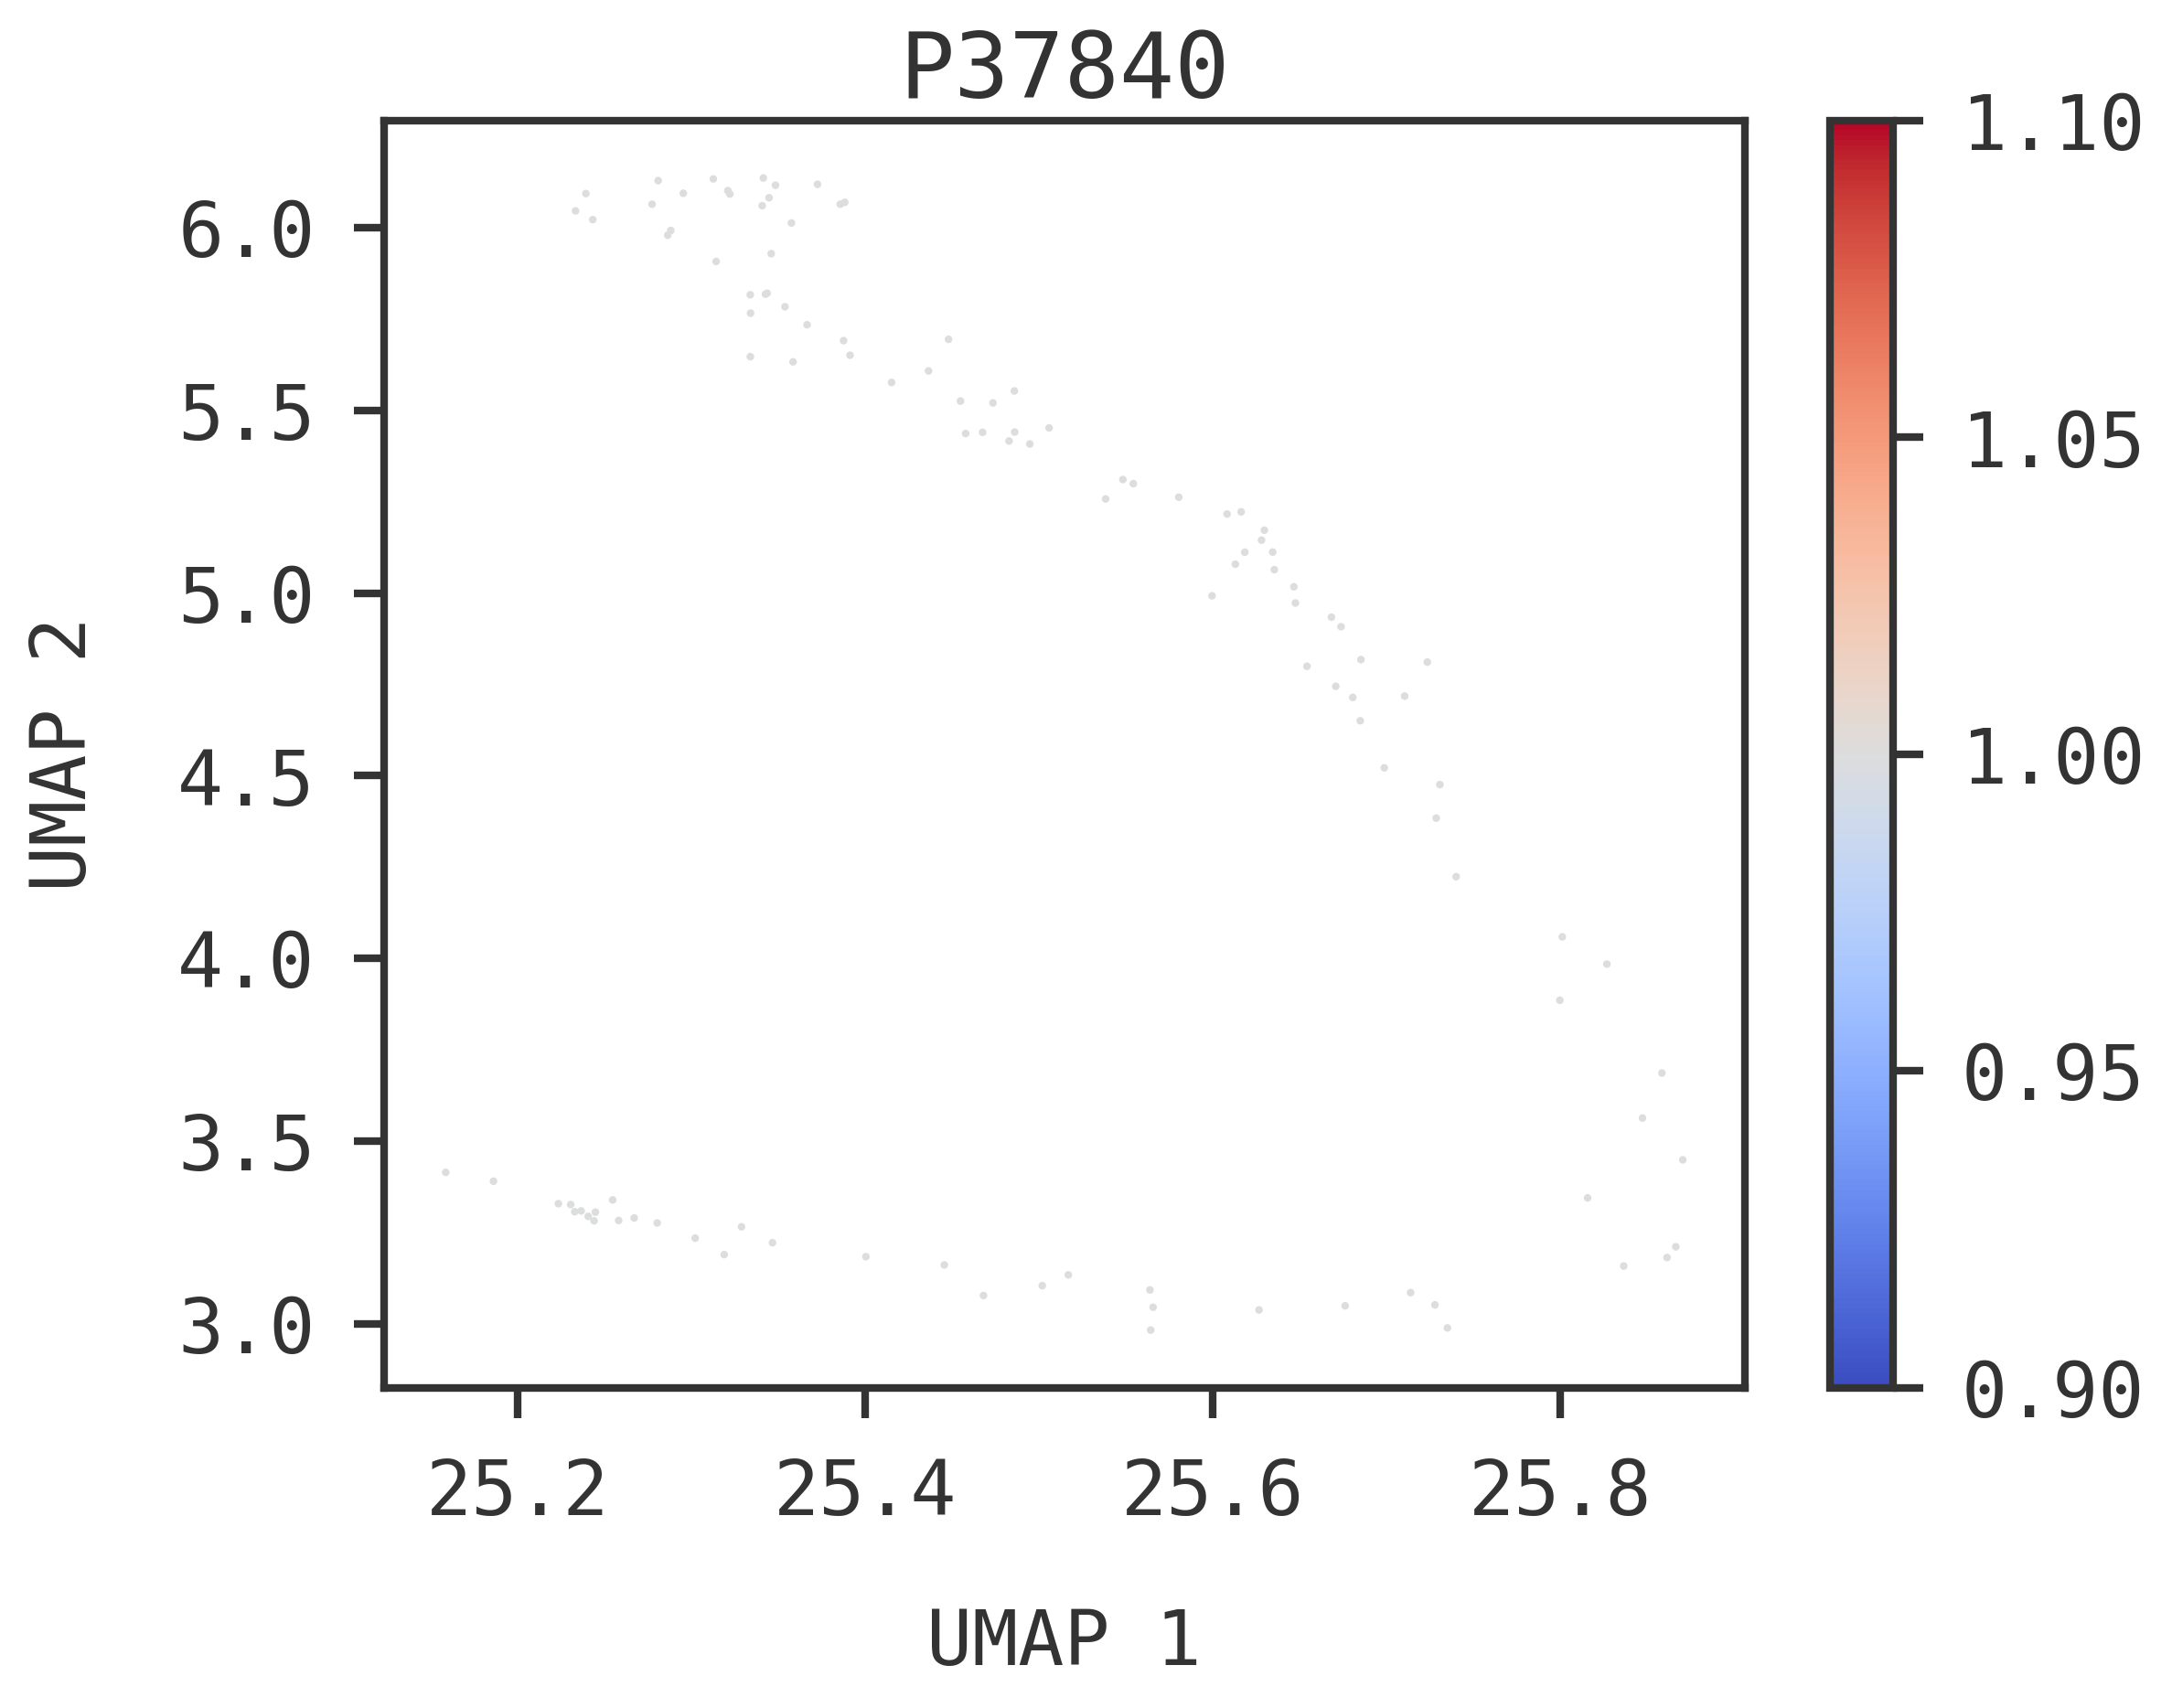

Q16186


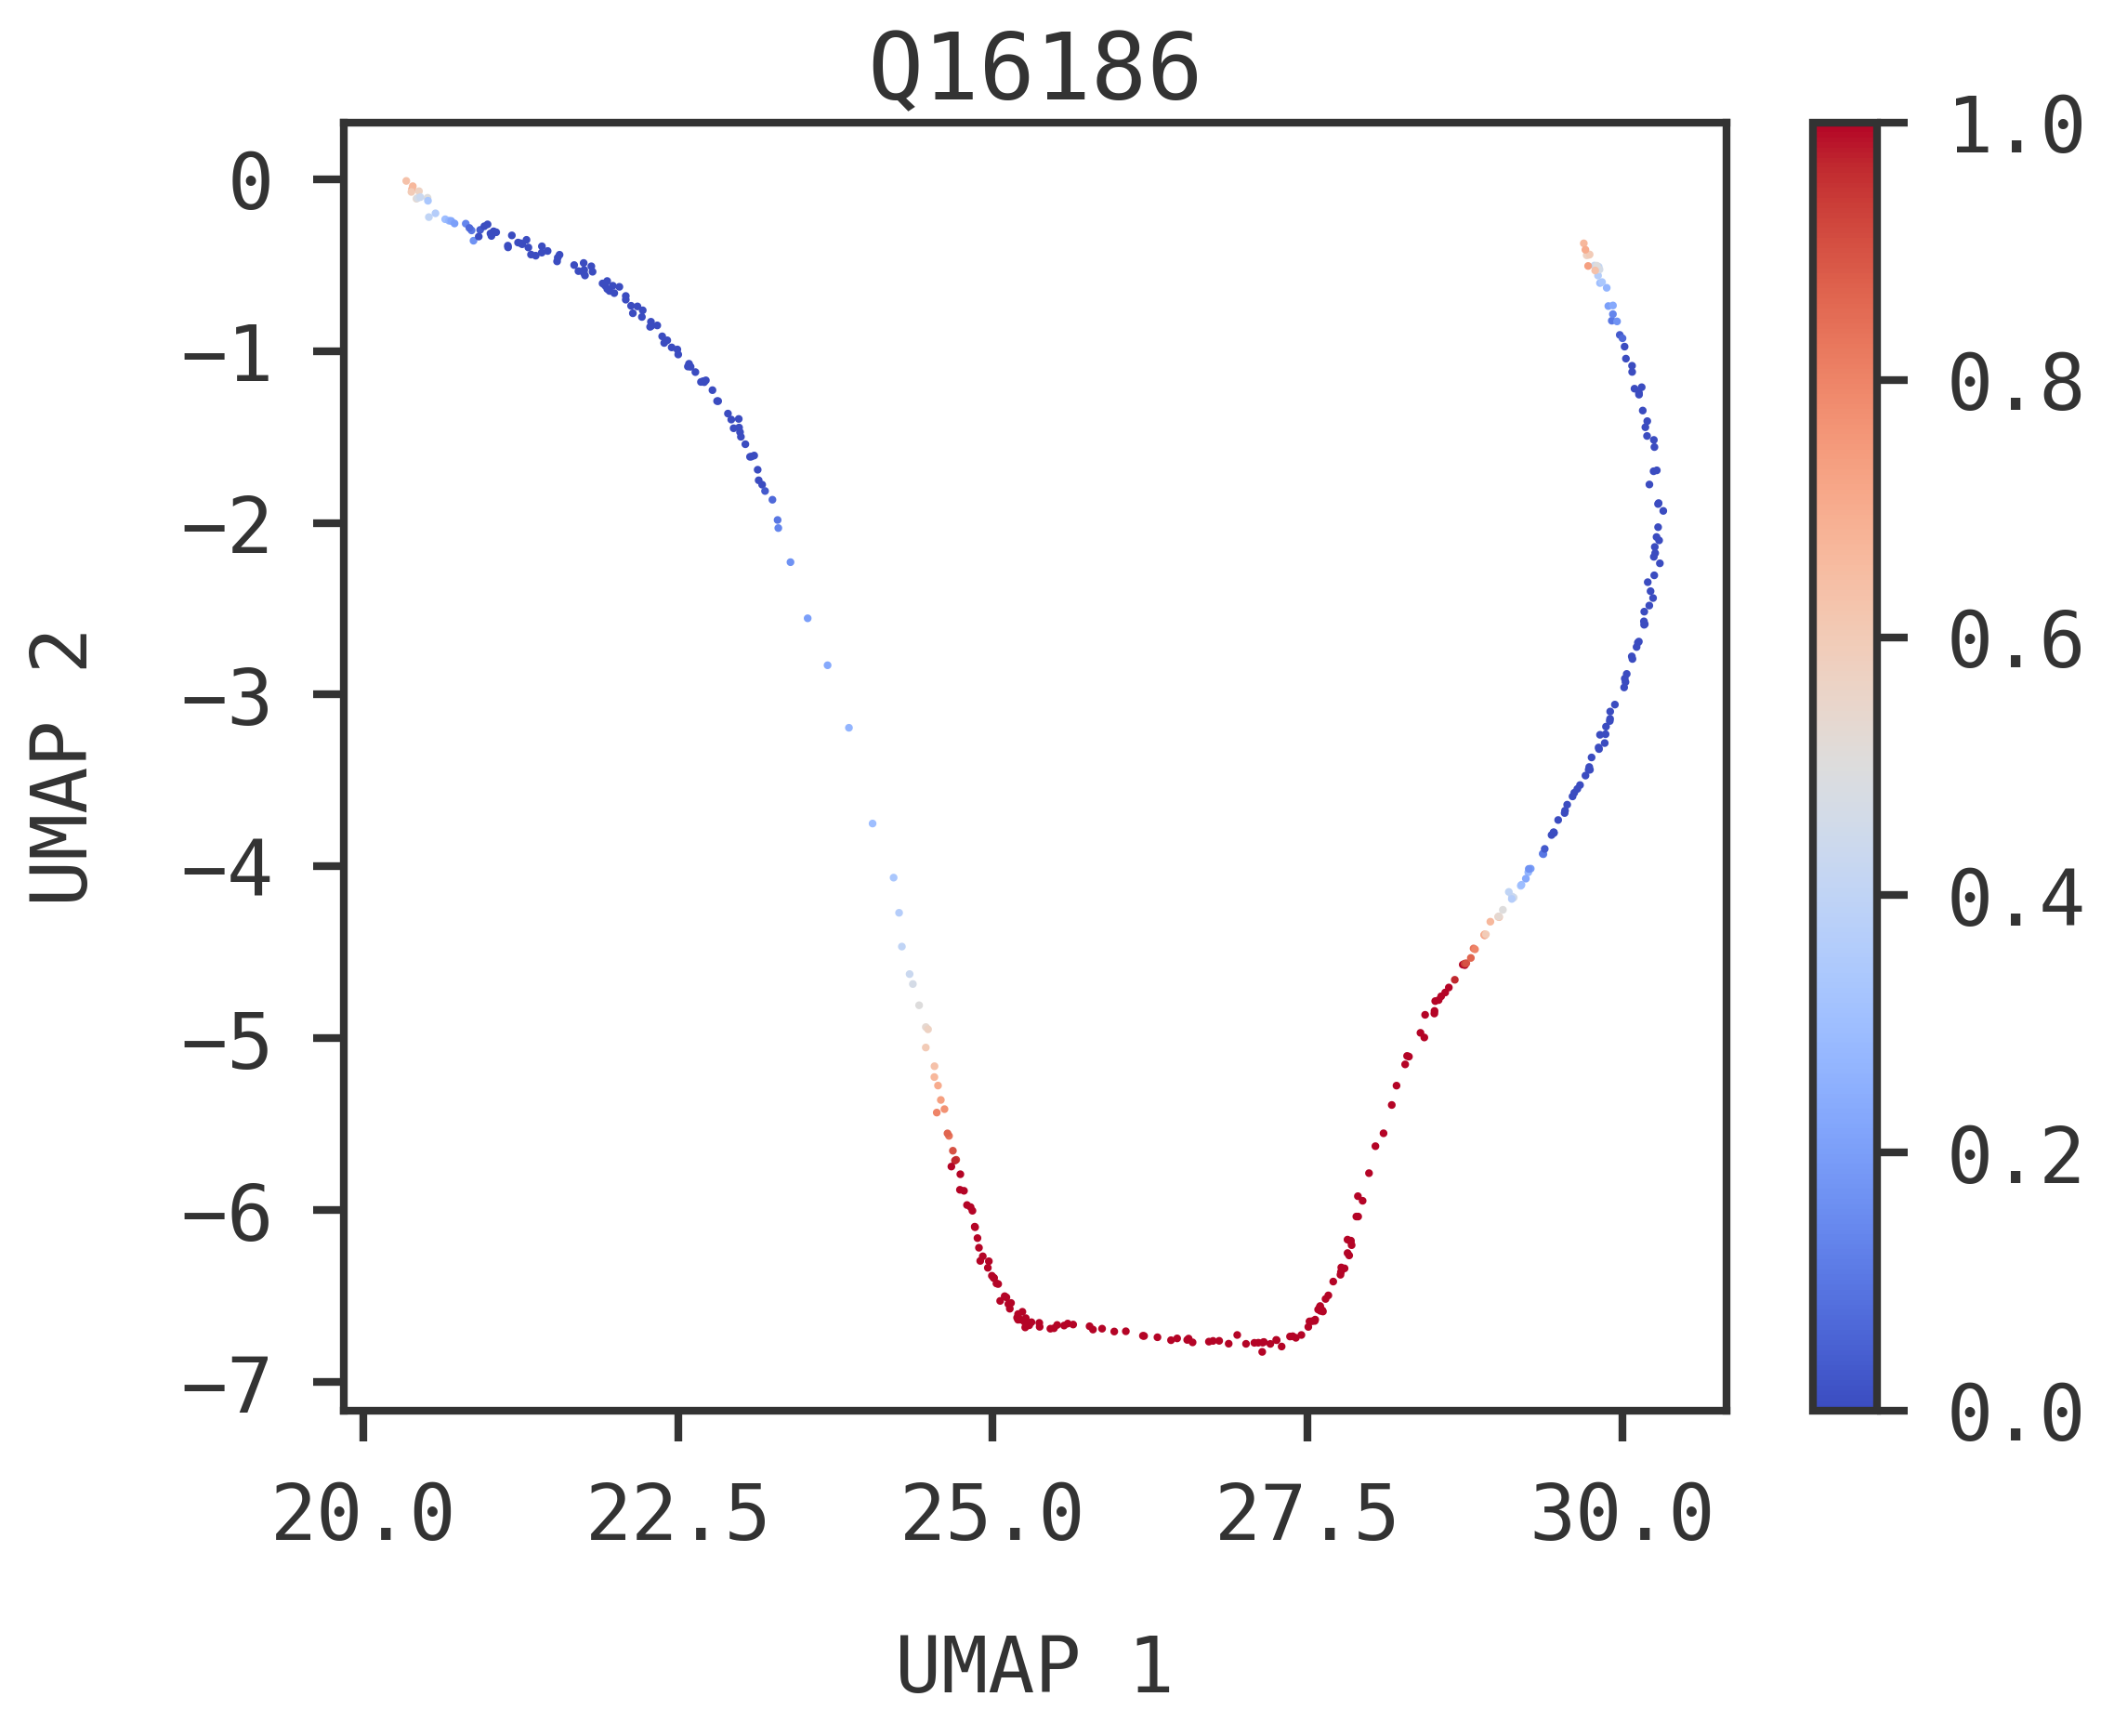

P02686


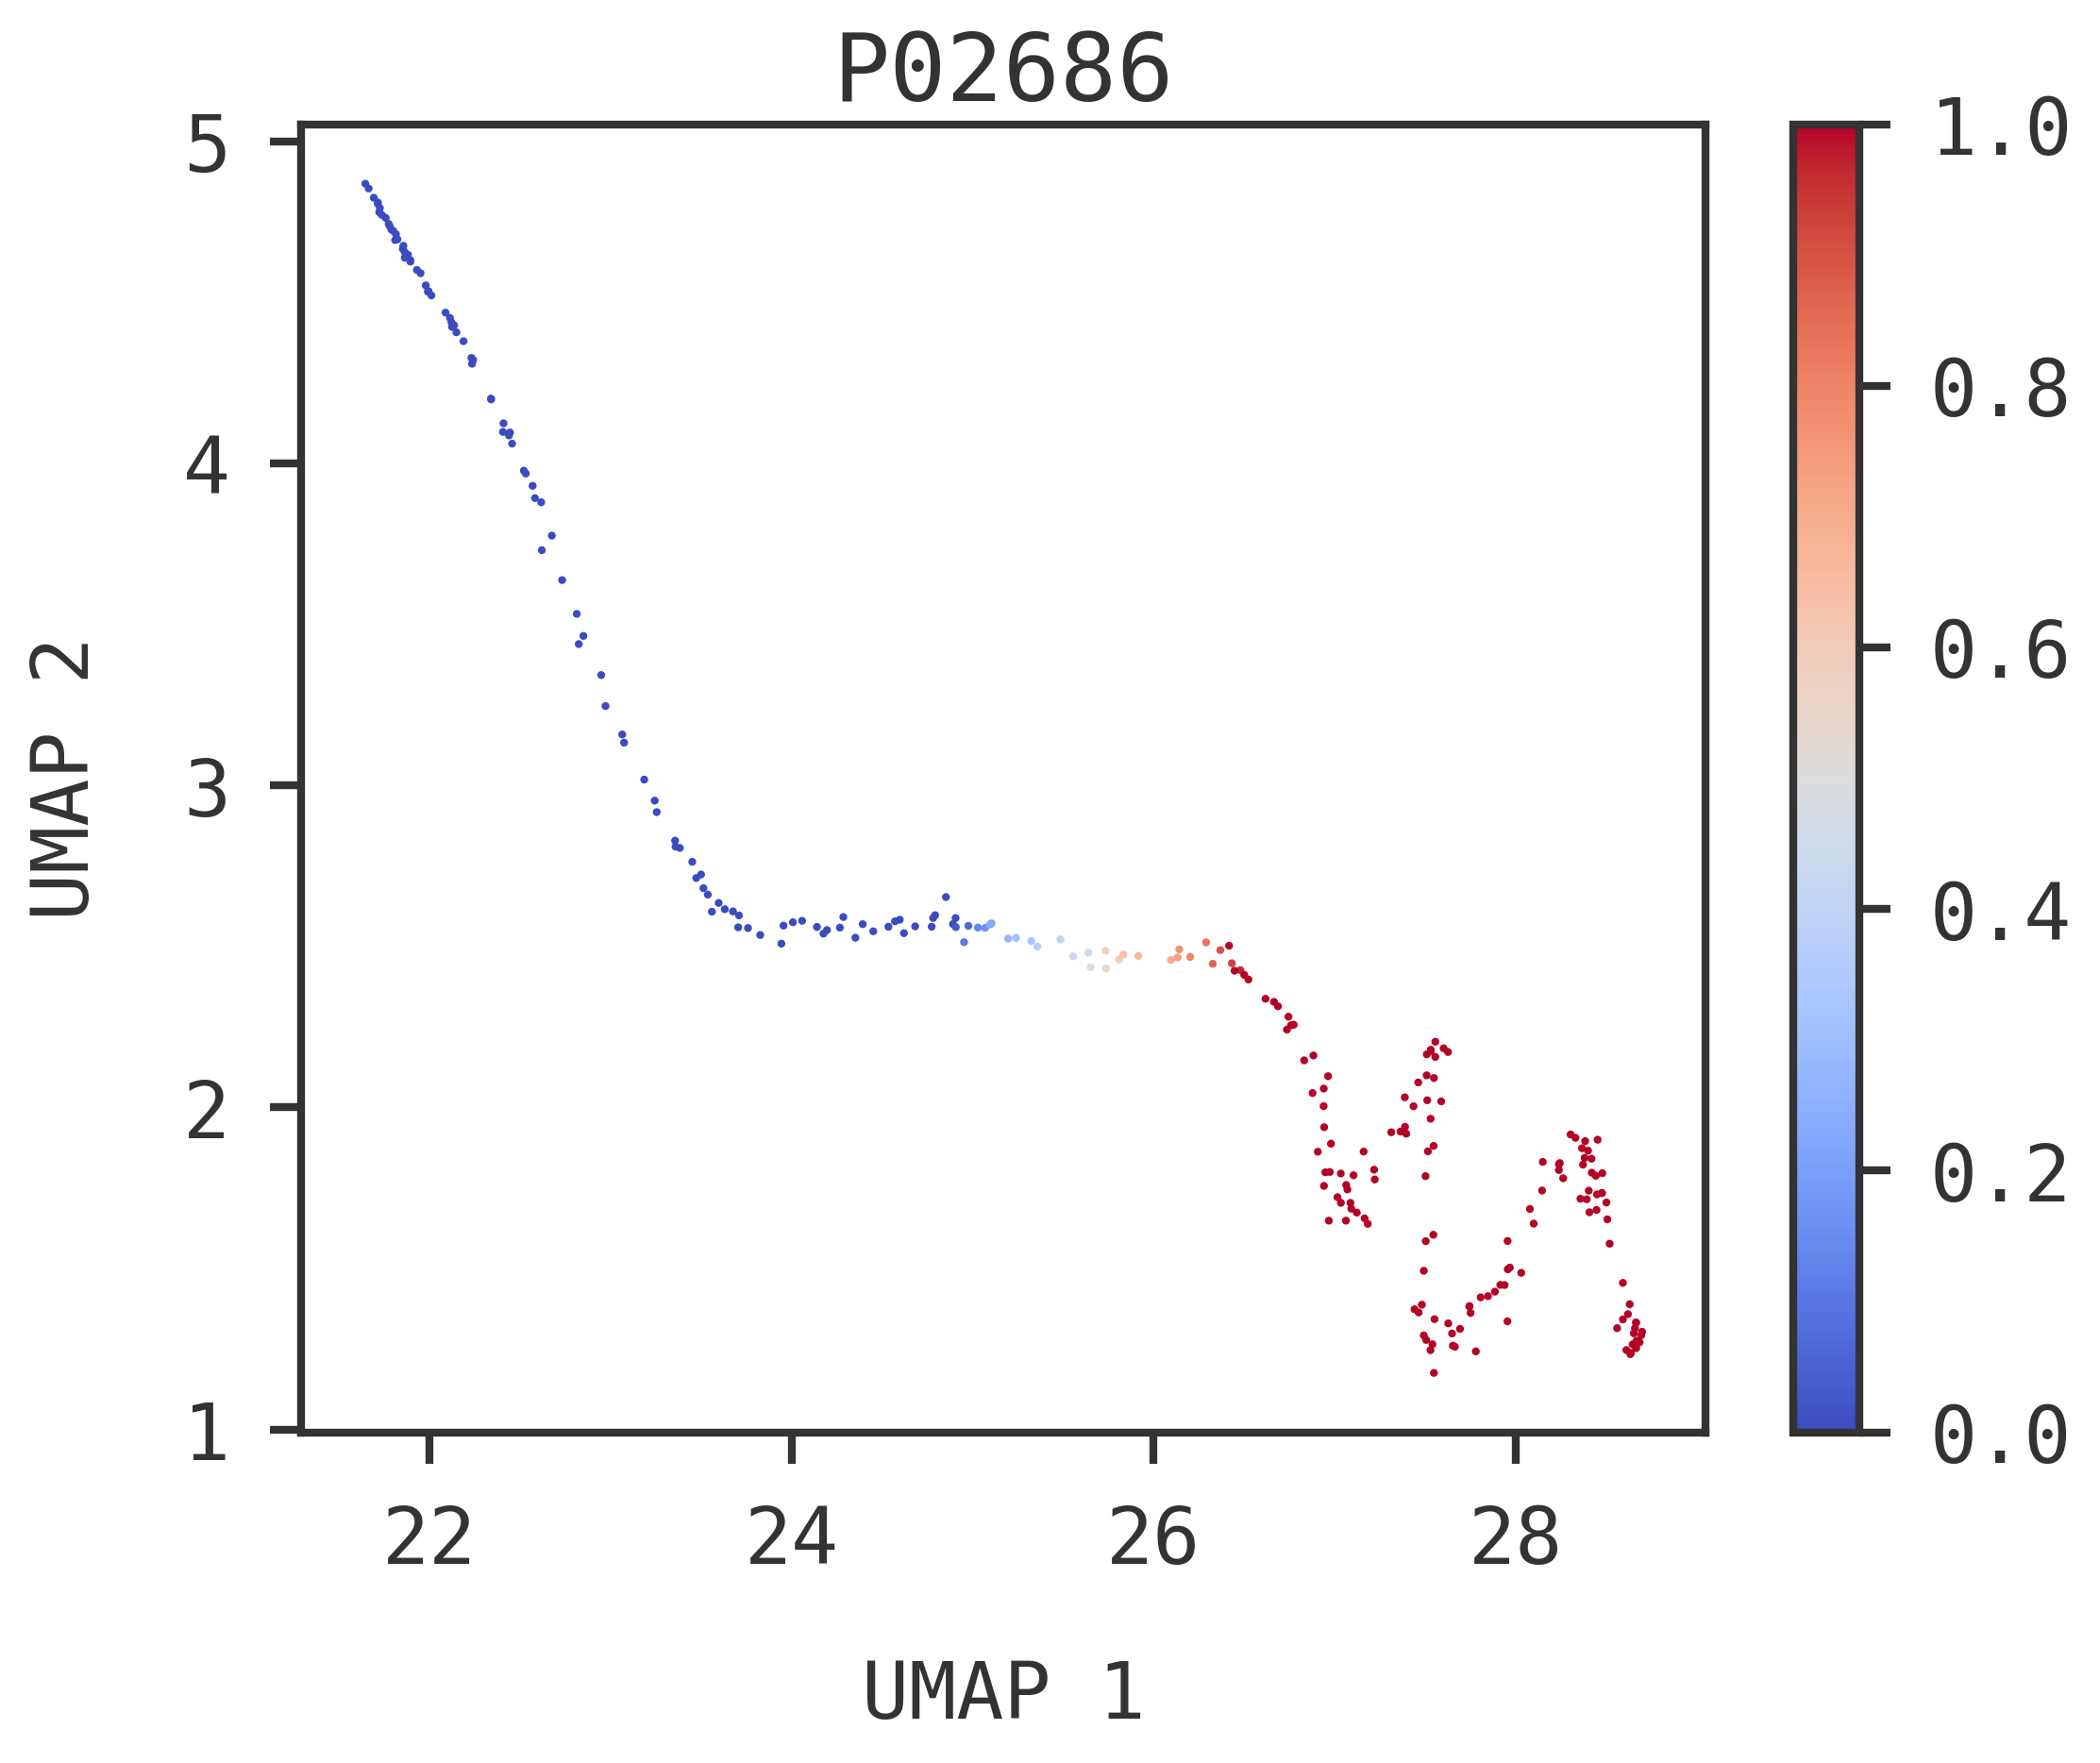

P23441


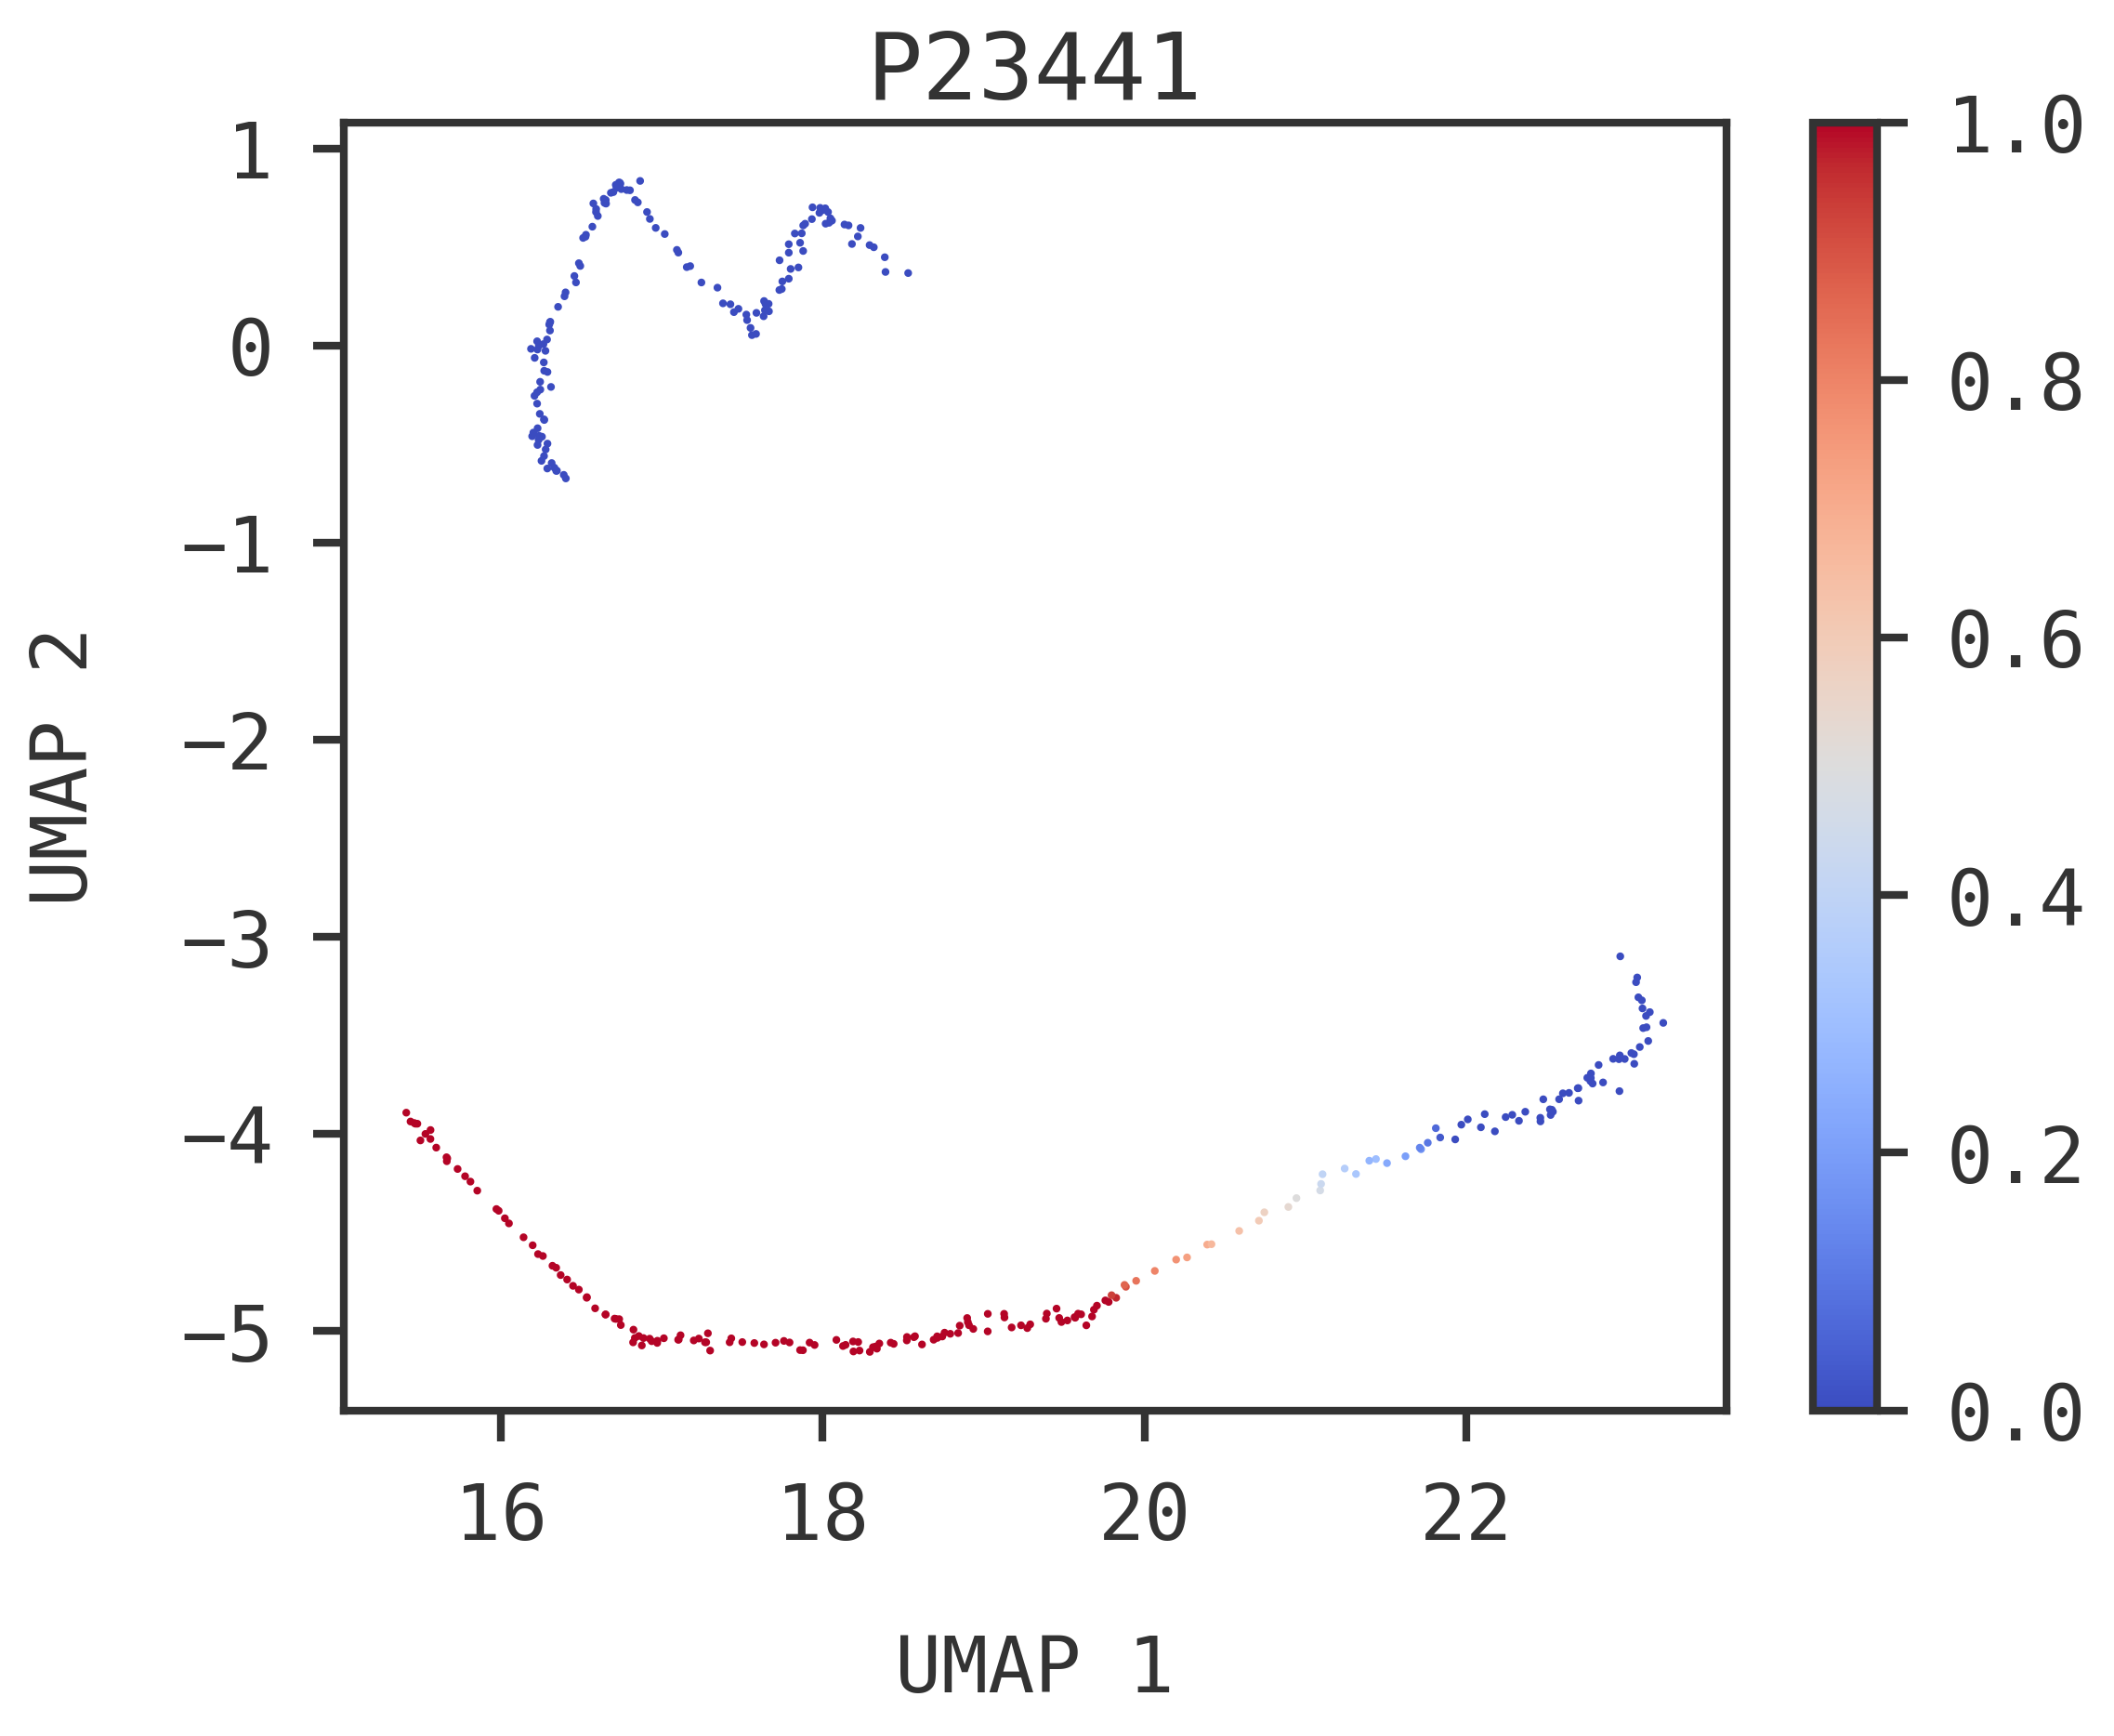

P04637


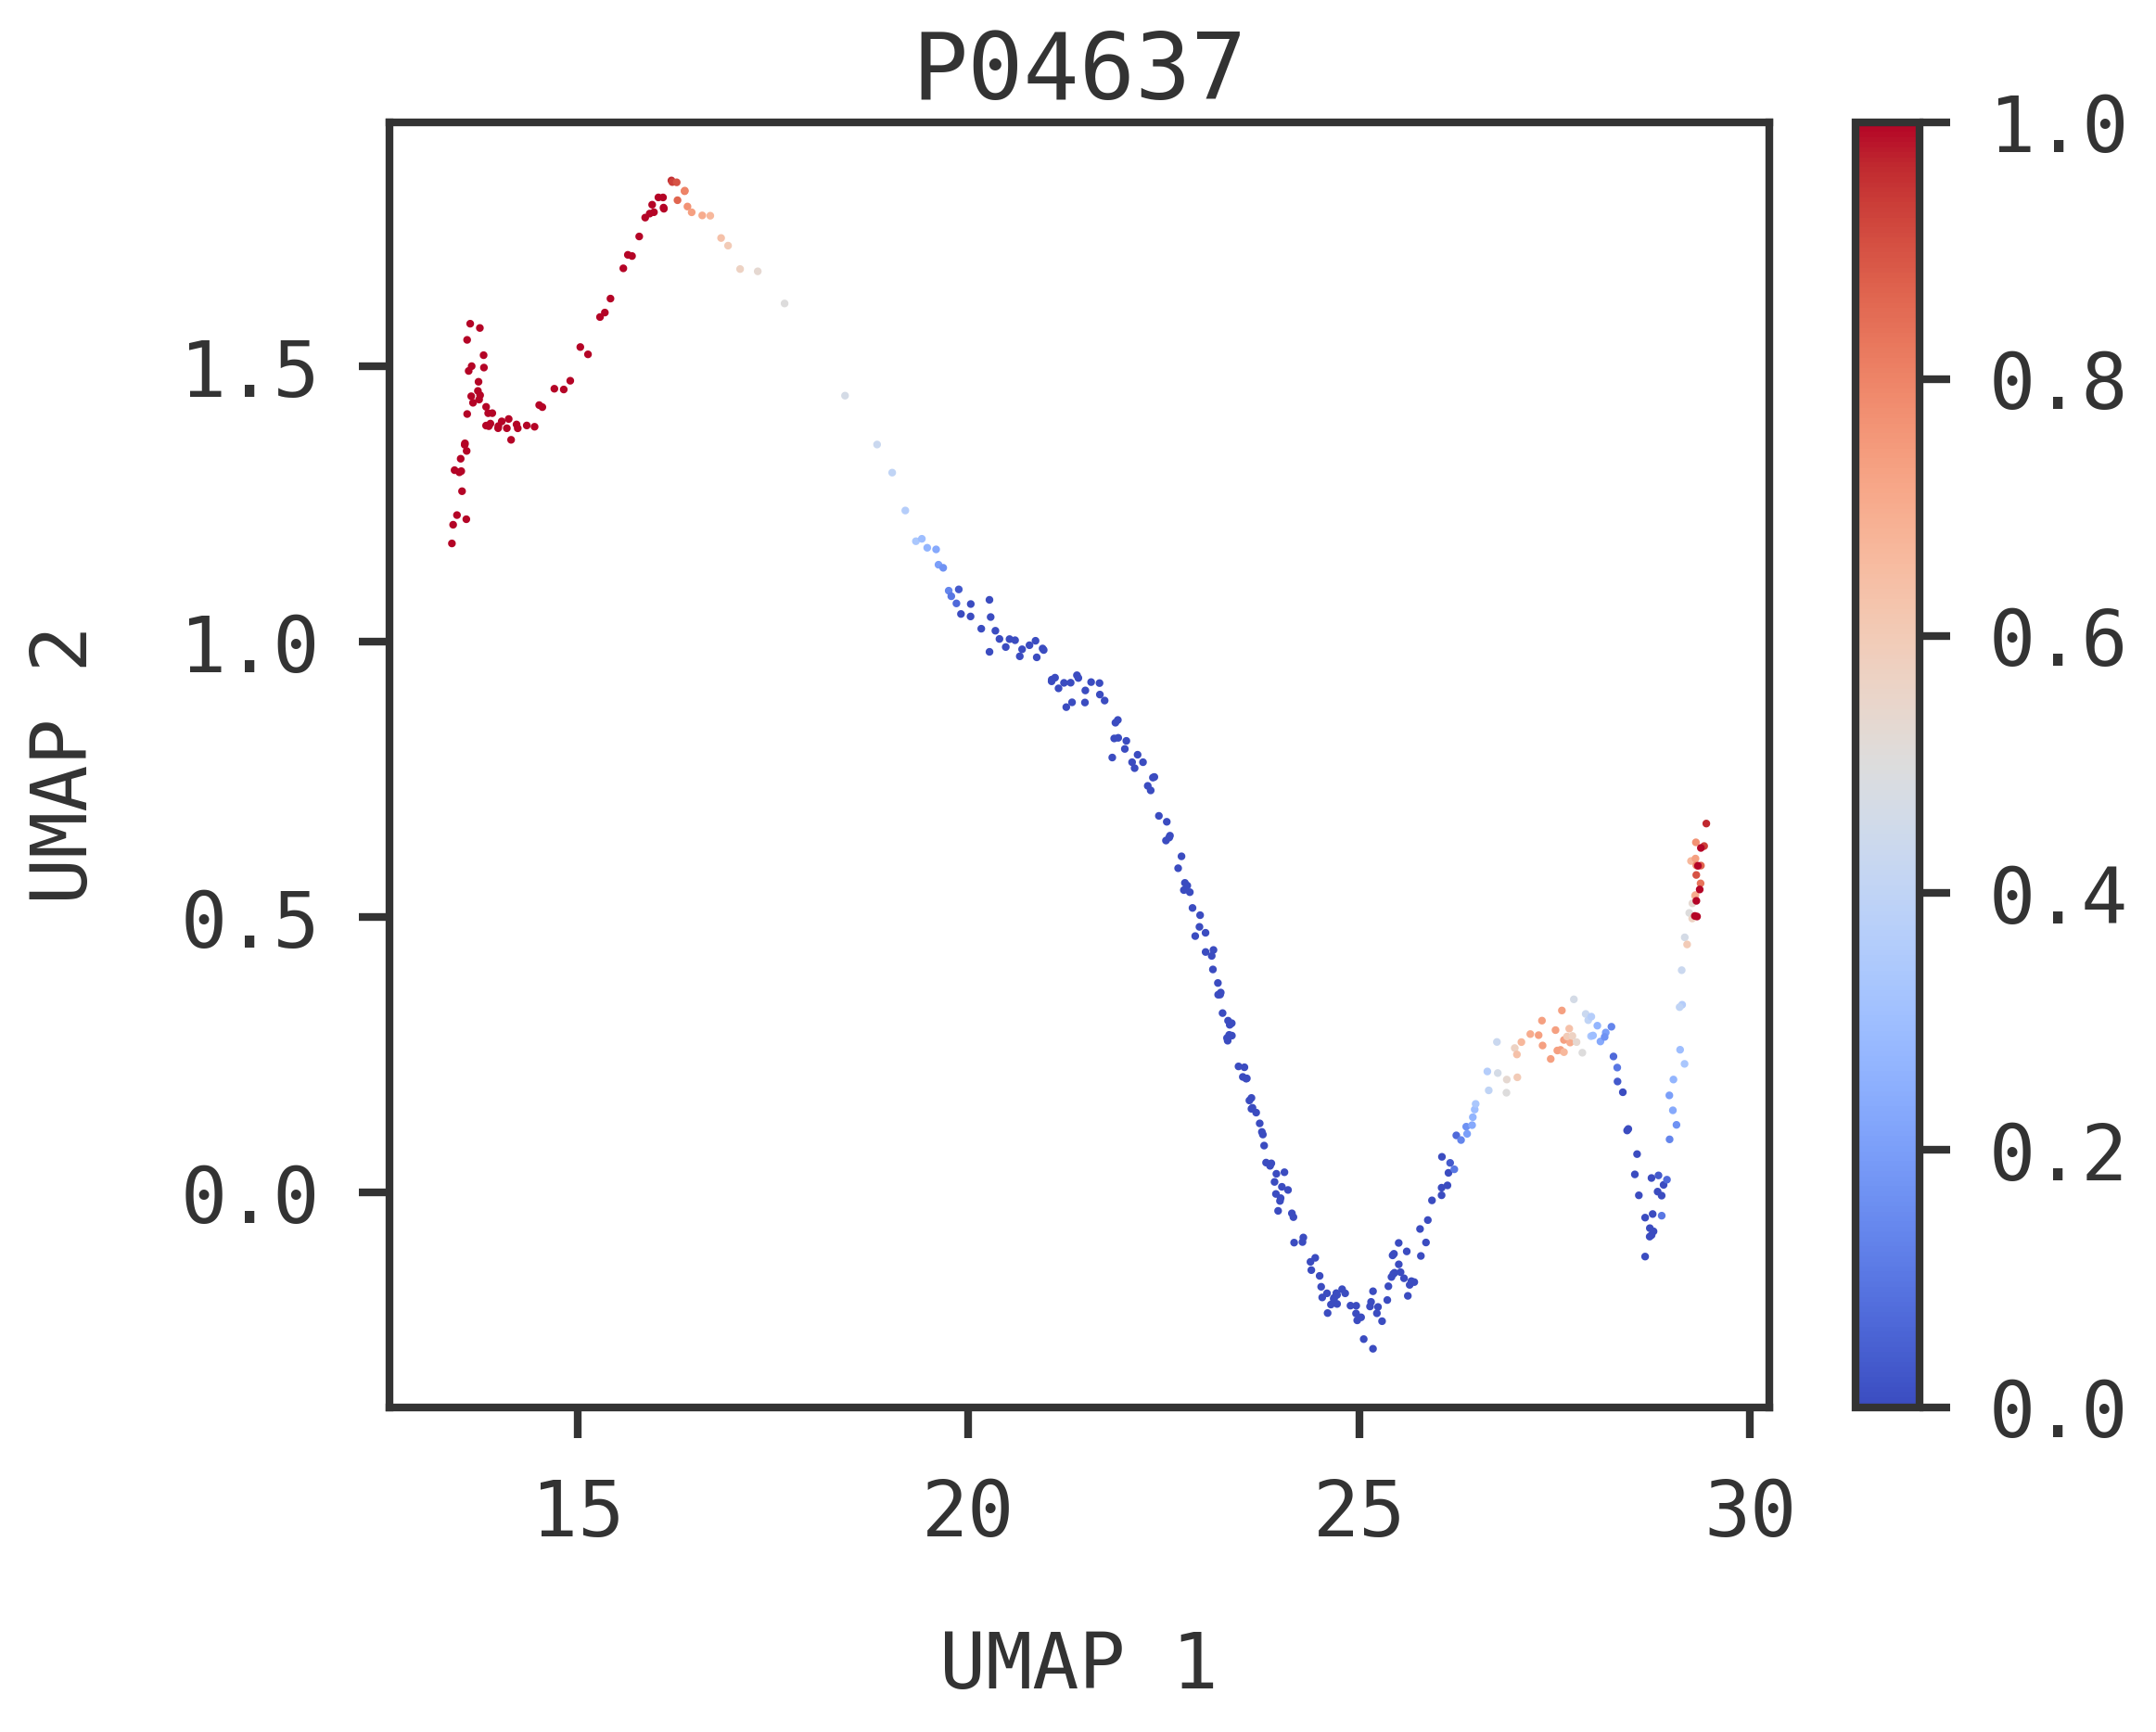

P07305


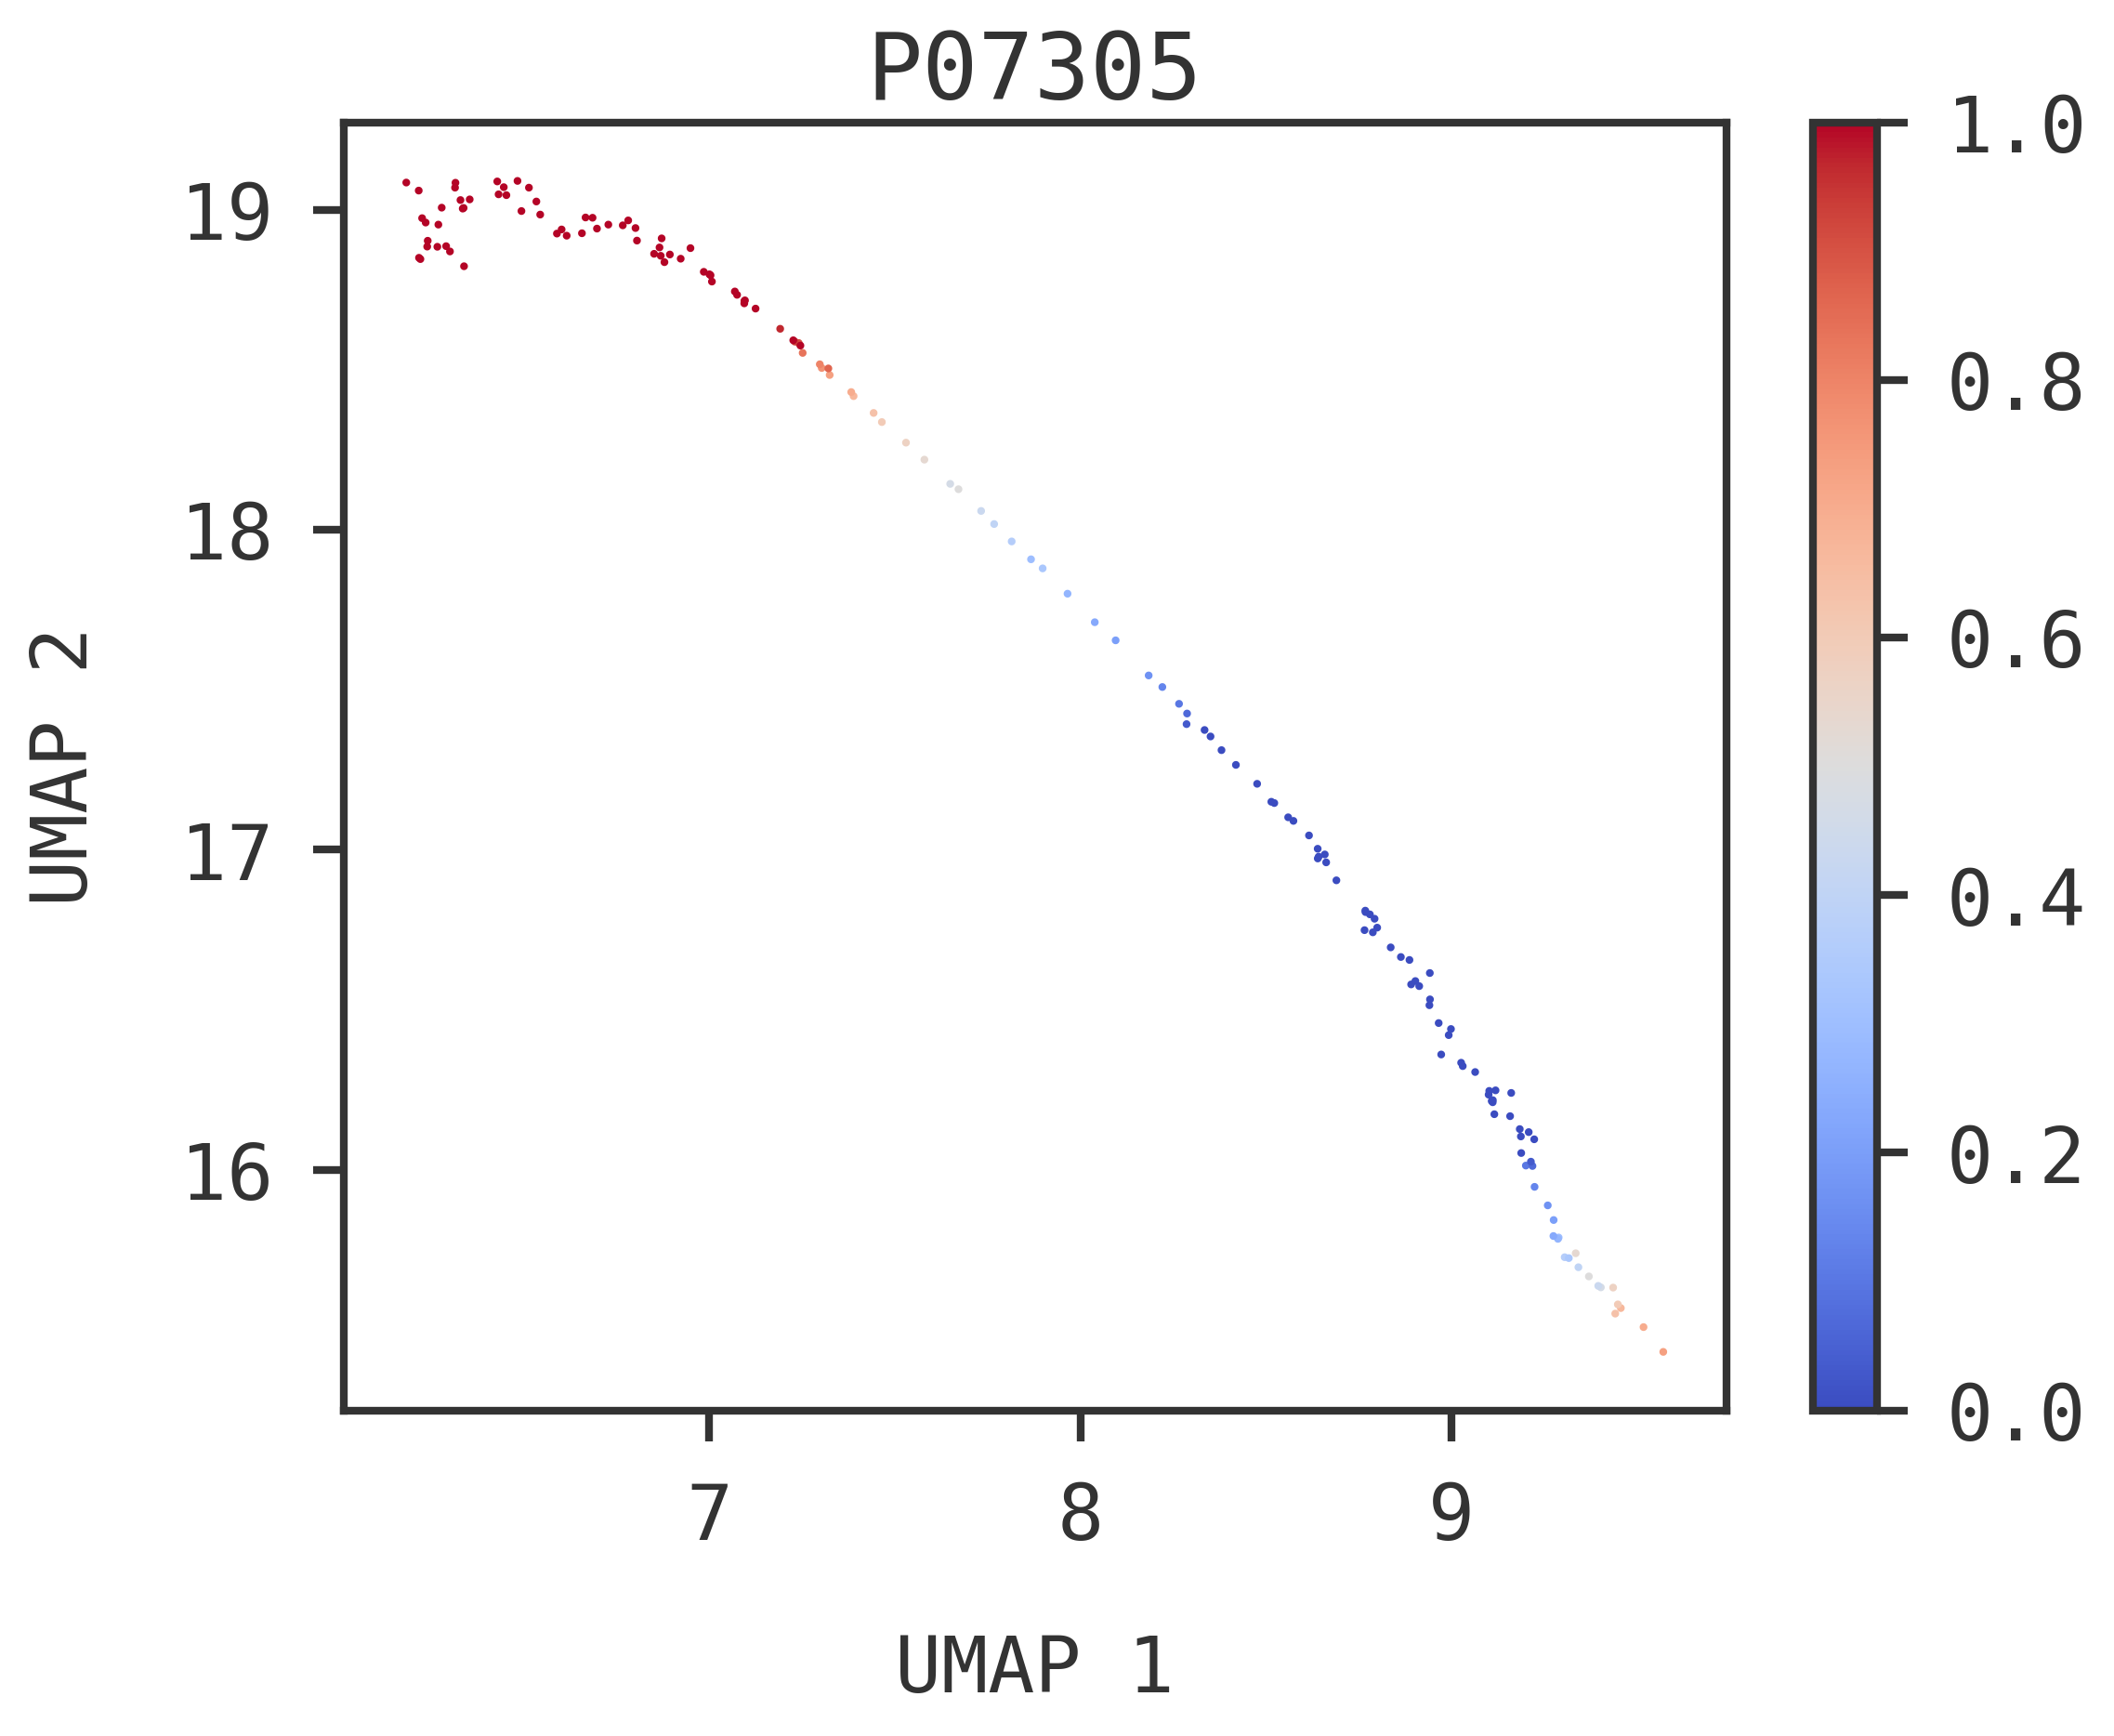

O00488


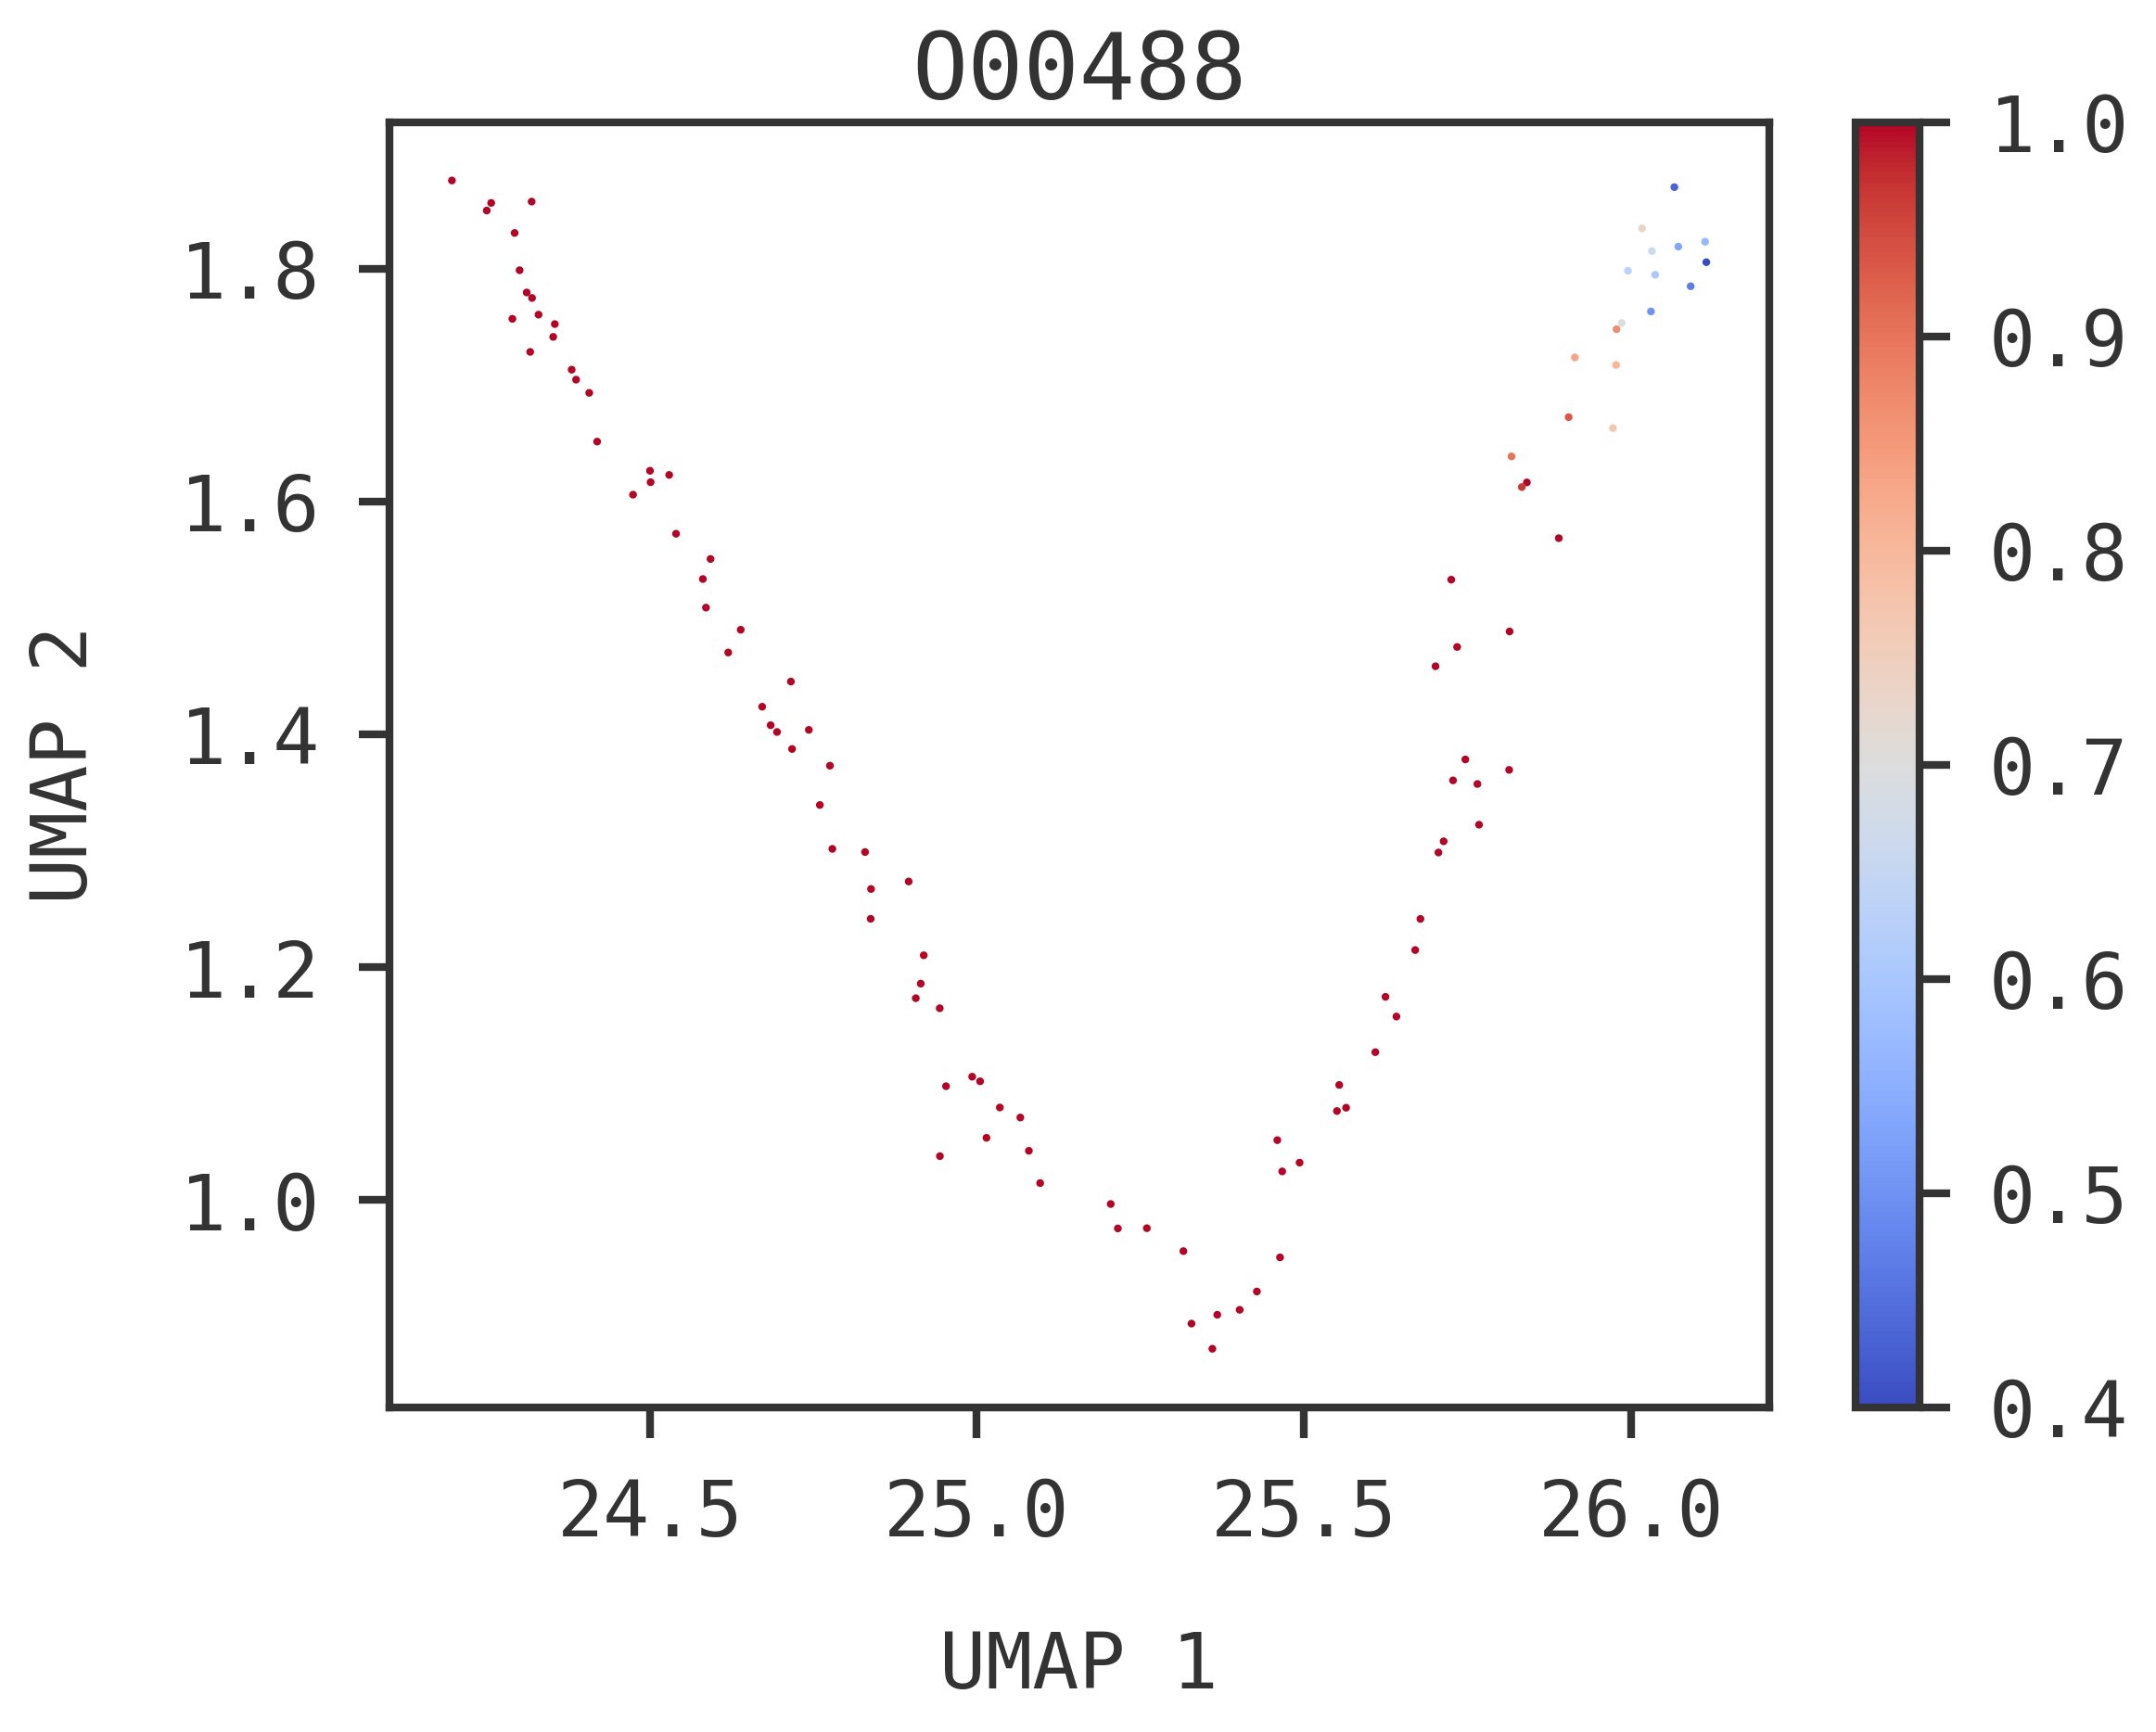

S6B291


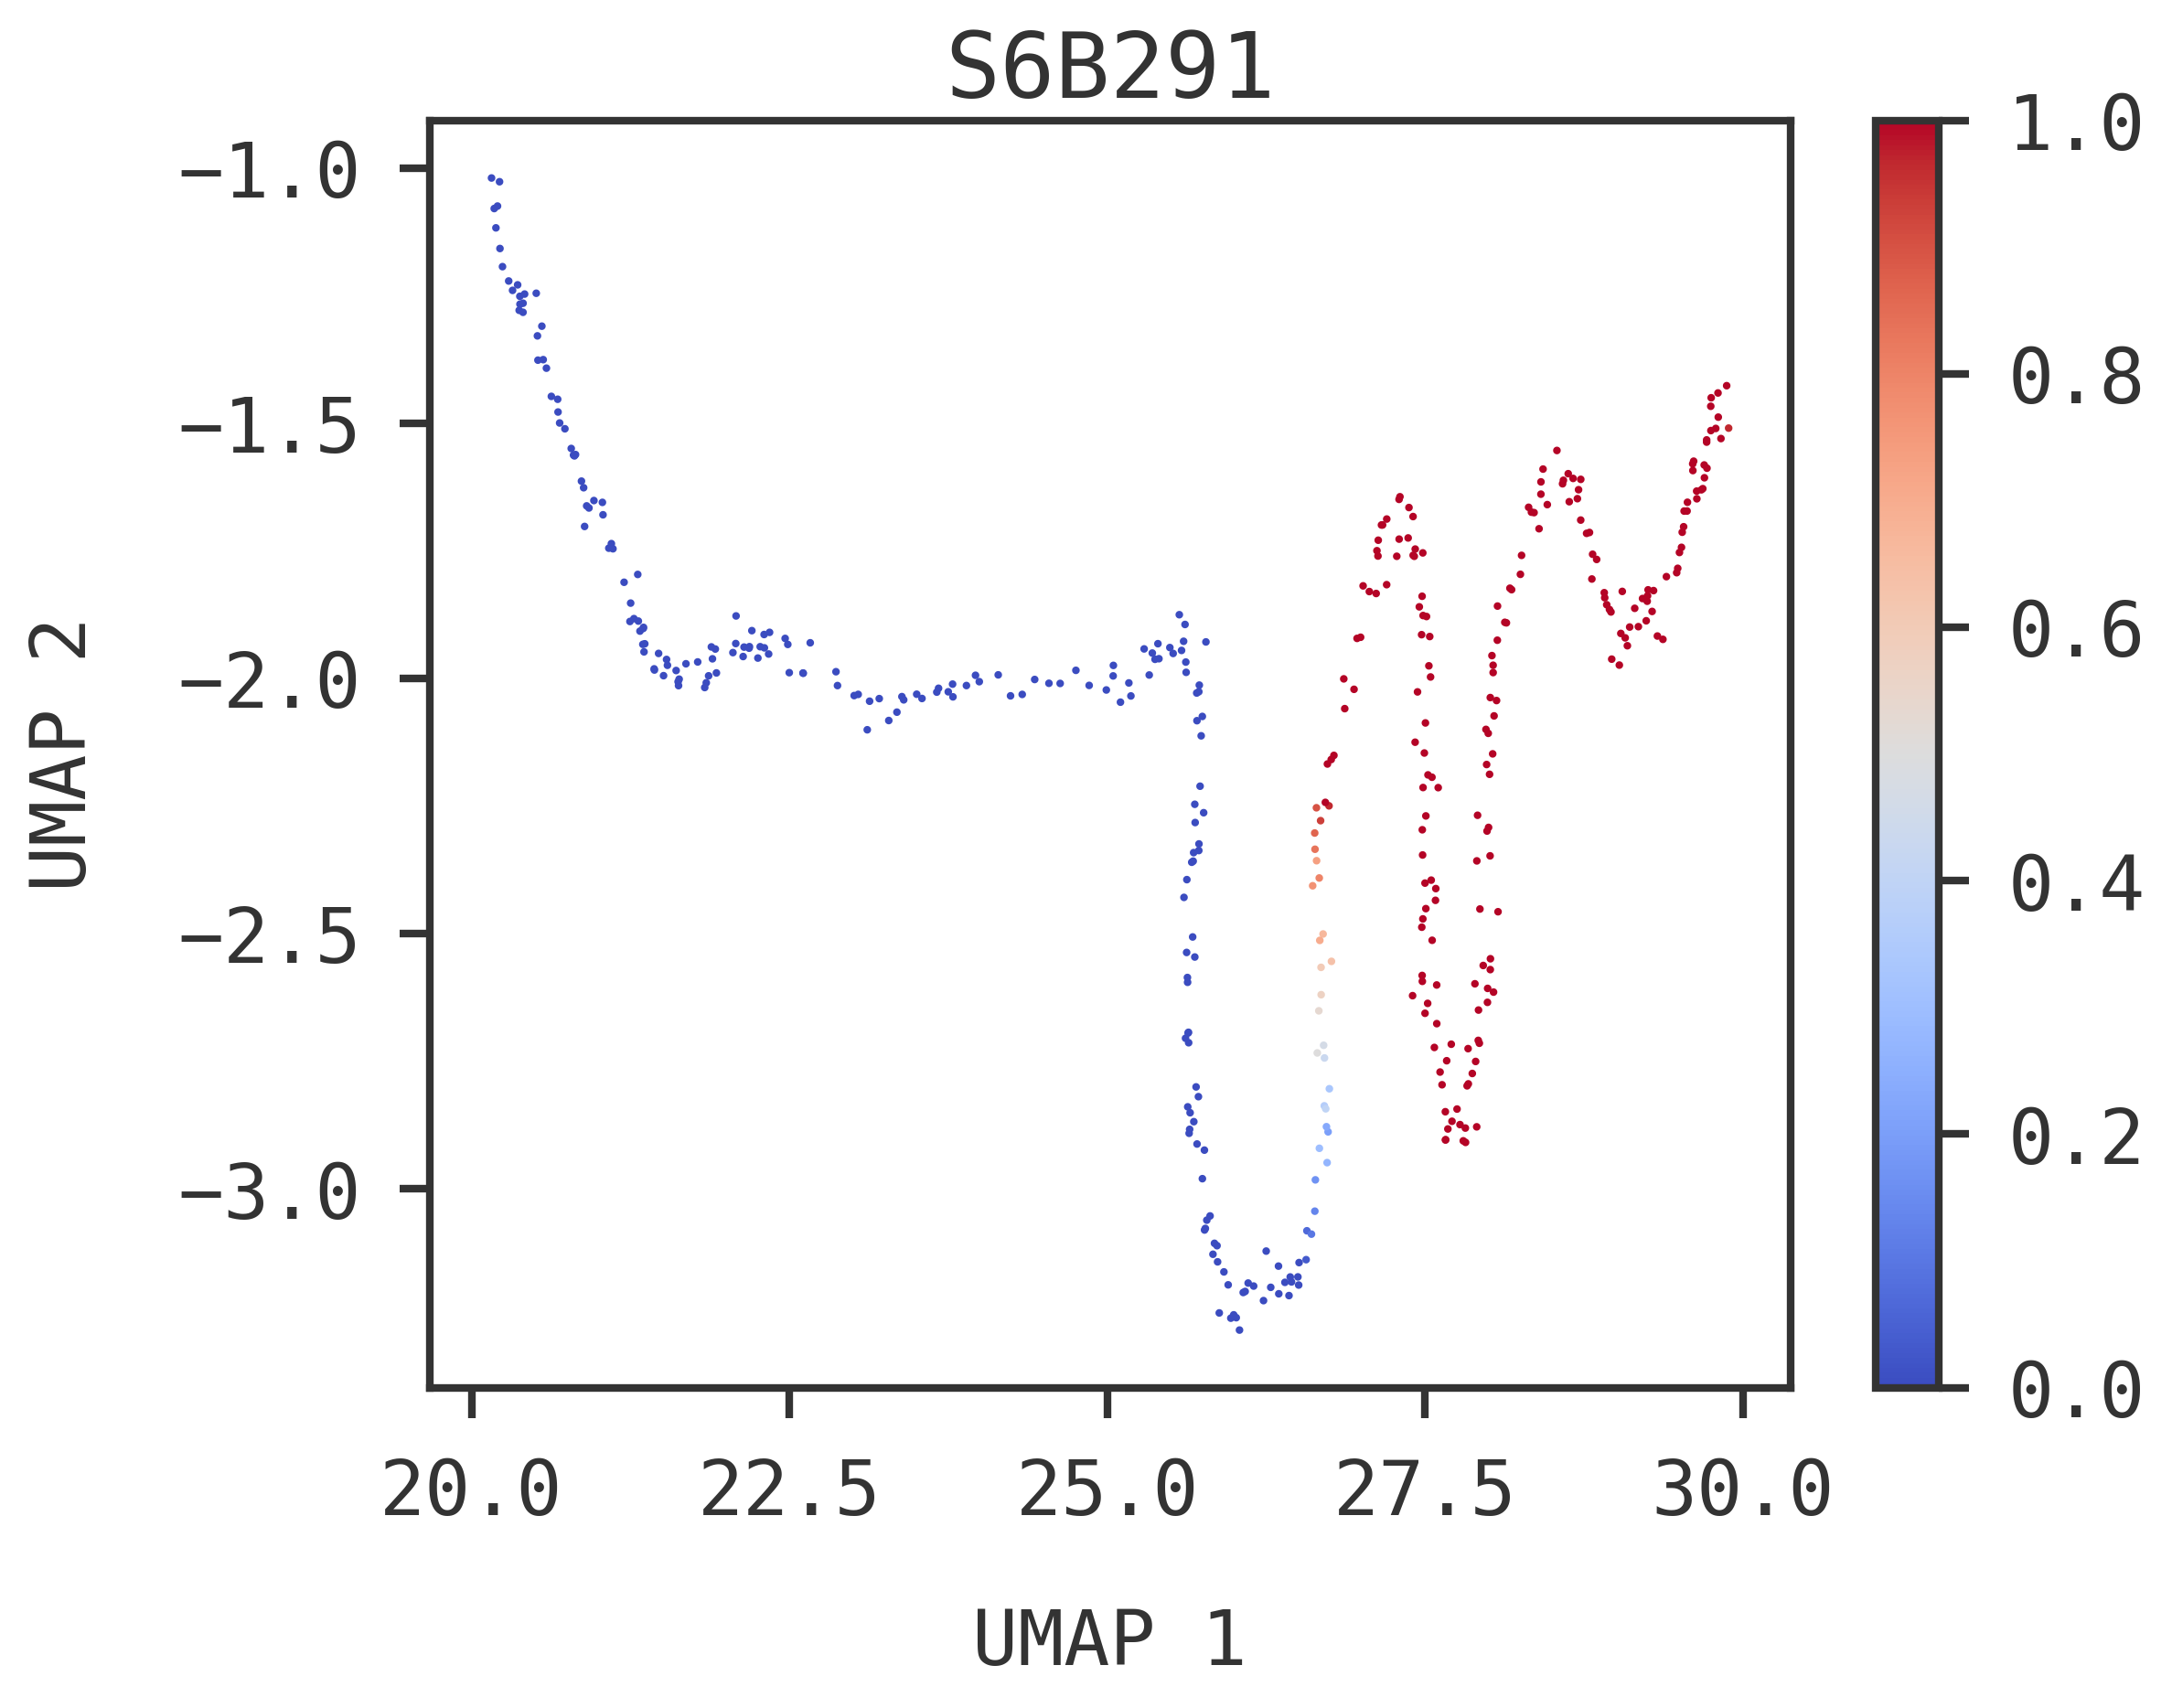

Q9NYB9


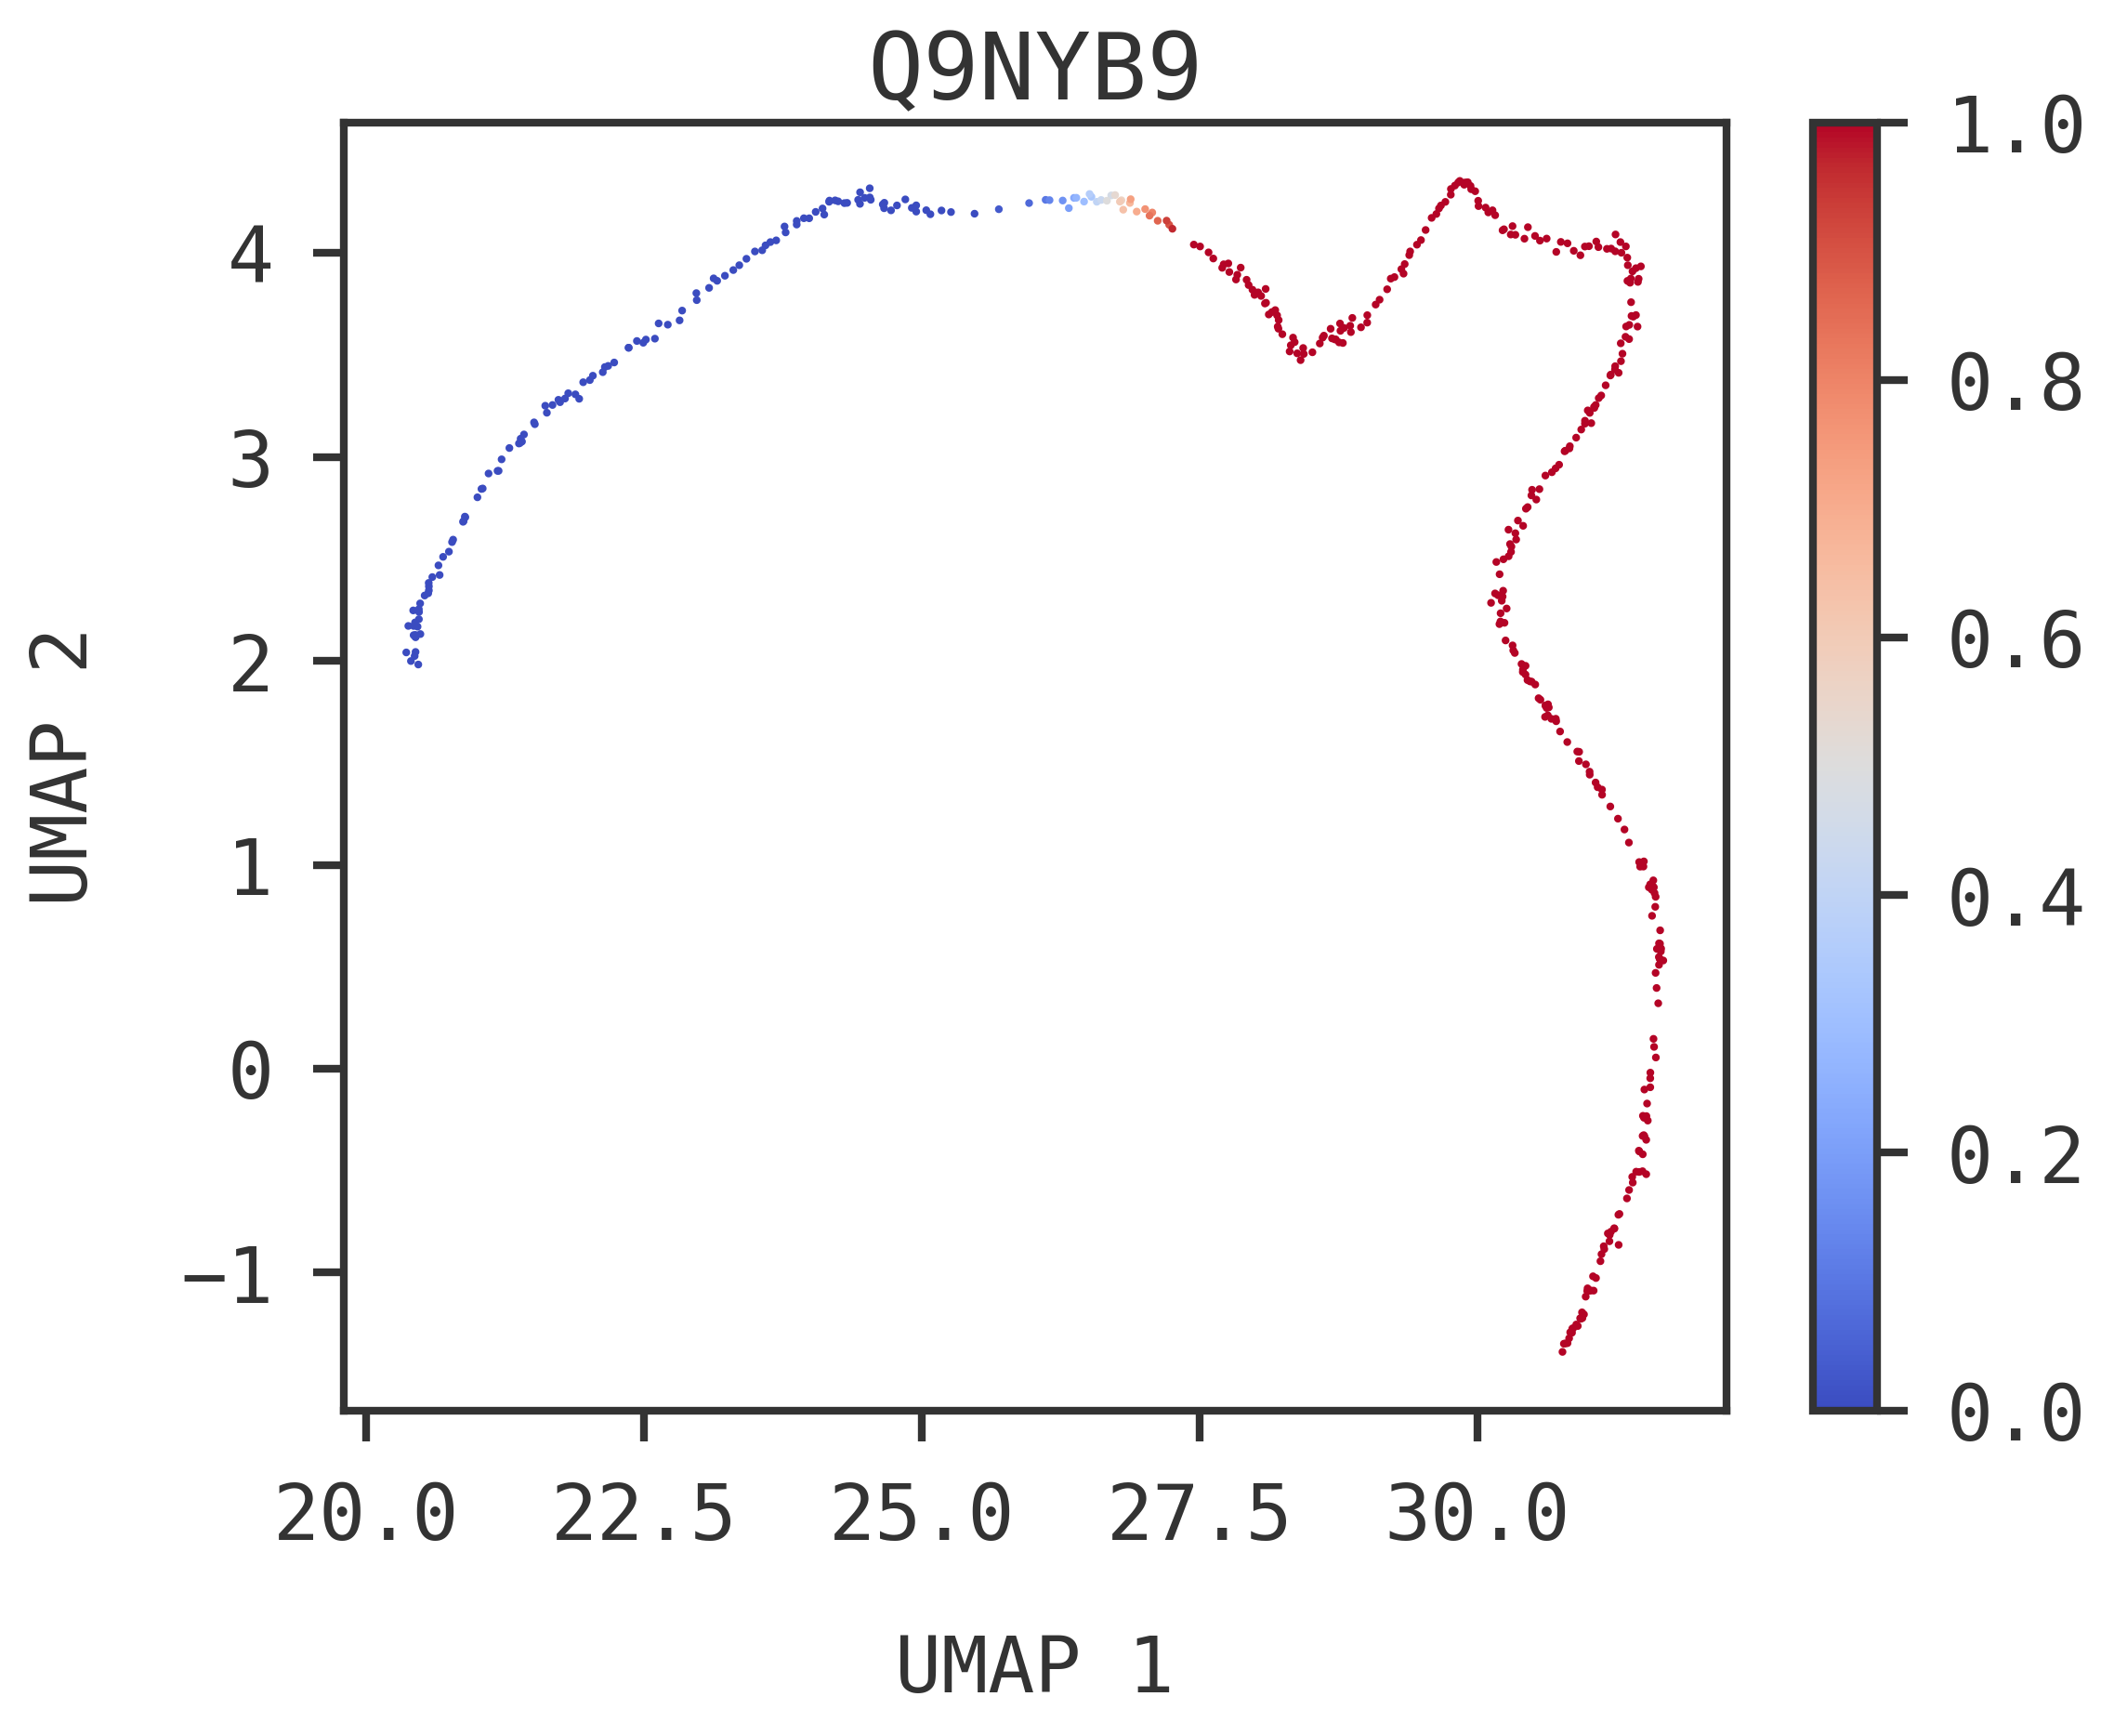

P06401


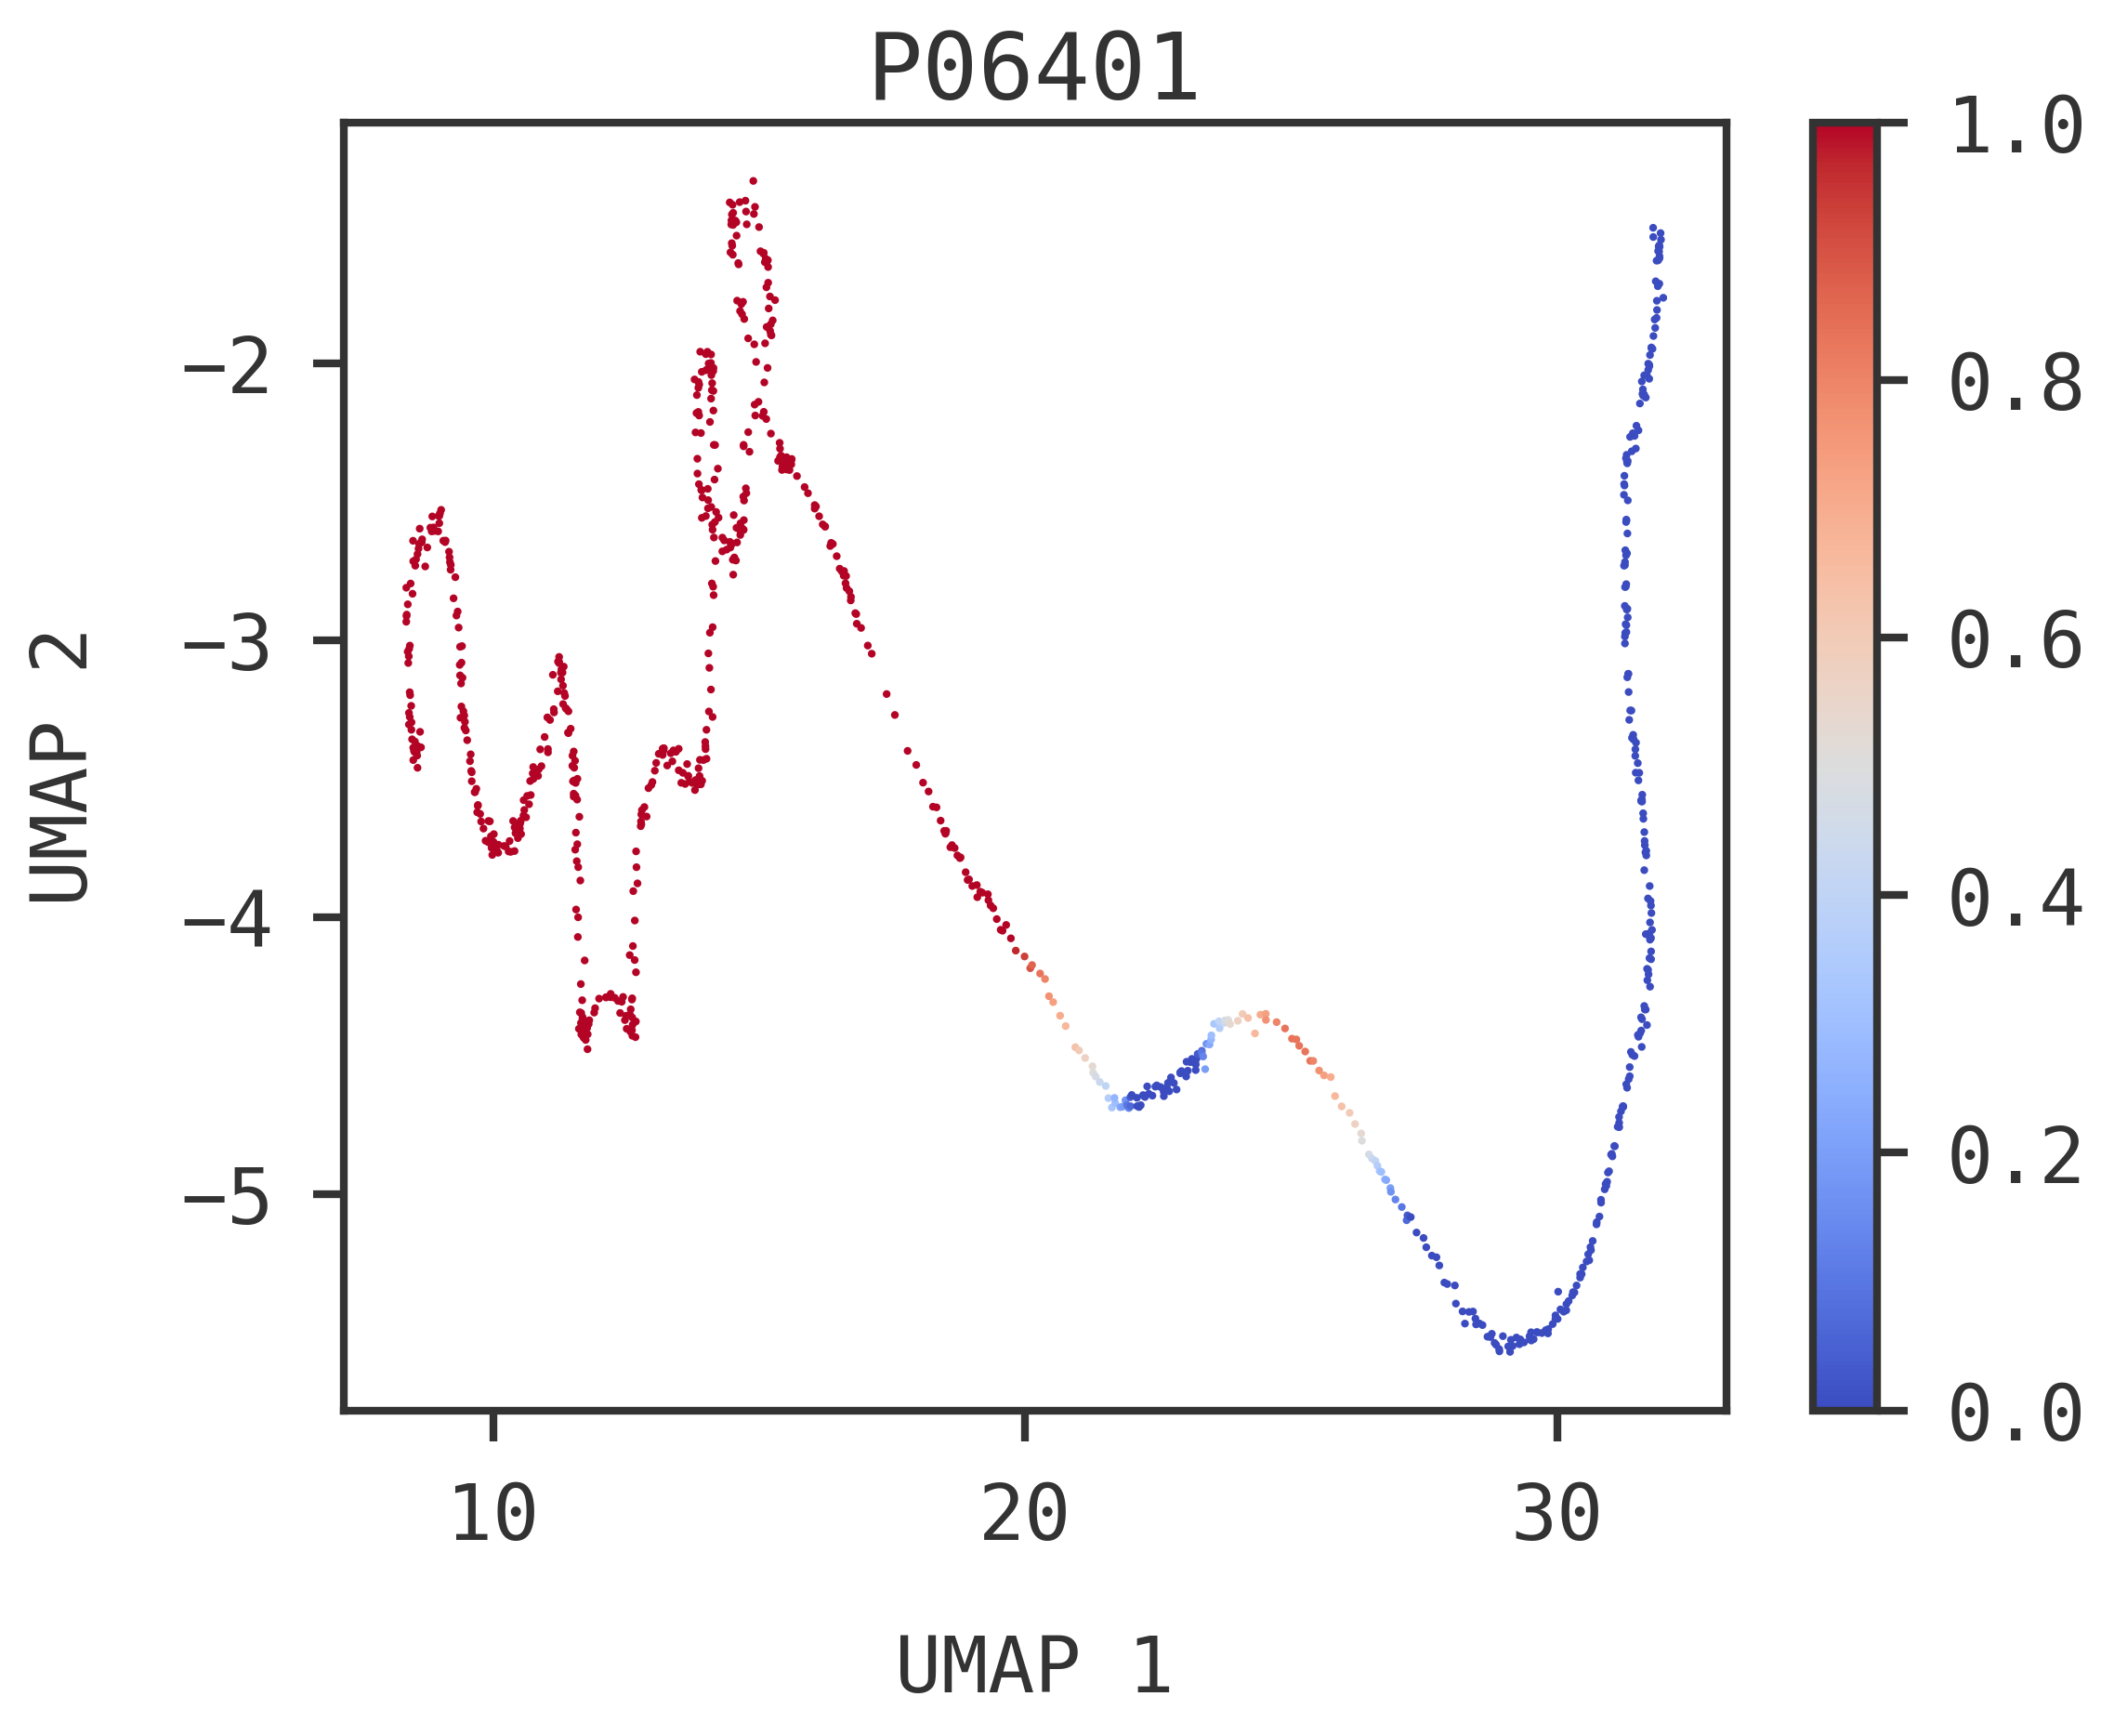

In [75]:
## single protein plot
for targ in uniprots:
    i_target = uniprots.index(targ)
    start = 0
    end   = 0
    print(uniprots[i_target])
    for j,dannot in enumerate(disprot_annotations):
        target_prot_kmers, _ = get_kmers(dannot, K=K)
        if i_target == j:
            end = start + len(target_prot_kmers)
            break
        else:
            start += len(target_prot_kmers)

    target_prot_ix = np.arange(start, end)

    fig = plt.figure(figsize=(8,6))
    ax1 = fig.add_subplot(111)

    cmap = plt.get_cmap("coolwarm")
    sc = ax1.scatter(umap_embedding[target_prot_ix,0], umap_embedding[target_prot_ix,1], c=np.array(disprot_kmer_disorder_contents)[target_prot_ix], s=1, cmap=cmap)
    ax1.set_xlabel("UMAP 1")
    ax1.set_ylabel("UMAP 2")
    ax1.set_title(f"{targ}")
    plt.colorbar(sc, ax=ax1)
    plt.show()

In [ ]:
# Load monomers embedding data
# plot onto the same umap
# paint disorder content
# find the dimensions that explaines the
# most disorder content (although this should be made for aa-level embedding)

In [25]:
# Load monomers embedding data
from Bio import SeqIO

counter = 0
embeddir = "/data/franco/datasets/prot_embedding_weights/monomers/halft5/"
embeddings_mono = list()
monomers_ids    = list()
multifasta_file = "/data/franco/datasets/disprot/monomers.fasta"
for record in SeqIO.parse(multifasta_file, "fasta"):
    if "|" in record.name:
        name = record.name.split("|")[1].strip()
    else:
        name = record.name.split()[0].strip()
        if name == "":
            print("Name is empty",record.name)
    embedfile = os.path.join(embeddir, f"{name}.gz")
    if os.path.exists(embedfile):
        #print(name)
        embeddings_mono.append(np.loadtxt(embedfile))
        monomers_ids.append(uniprot_id)
        counter += 1
    if counter >= 10:
        break
print(f"Loaded {counter} protein embeddings")

Loaded 10 protein embeddings


In [41]:
my_umap = umap.UMAP(n_neighbors=200, min_dist=.25)
umap_embedding_mono = my_umap.fit_transform(np.vstack(embeddings_mono))


In [40]:
np.vstack(embeddings_mono).shape

(1822, 1024)

In [ ]:
# obtain kmer embeddings from original whole protein embedding, and apply mean function
K = 30
monomer_kmer_mean_embeddings = list()
for single_emb in embeddings_mono:
    emb_kmer  = get_embedding_kmers(single_emb, K=K)
    emb_kmers = [np.mean(x, axis=0) for x in emb_kmer] # make a list of mean embedding kmers
    monomer_kmer_mean_embeddings = monomer_kmer_mean_embeddings + emb_kmers
print(len(monomer_kmer_mean_embeddings))